<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

In [3]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### Loading the data

In [4]:
# Load the data
house = pd.read_csv('./house.csv')

In [5]:
house.columns

Index(['id', 'property_subclass', 'property_zoning', 'lot_frontage',
       'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighbourhood', 'condition_1',
       'condition_2', 'property_type', 'house_style', 'overall_quality',
       'overall_condition', 'year_built', 'year_remodernisation_added',
       'roof_style', 'roof_matl', 'exterior_material_1', 'exterior_material_2',
       'masonry_veneer_type', 'masonry_veneer_area',
       'external_material_quality', 'external_material_condition',
       'foundation', 'basement_height_quality', 'basement_condition',
       'basement_exposure', 'basement_finished_area_quality_type1',
       'basement_type1_sqf', 'basement_finished_area_quality_type2',
       'basement_type2_sqf', 'basement_unfinished_sqf',
       'total_basement_area_sqft', 'heating', 'heating_quality',
       'air_conditioning', 'electrical', 'First_floor_sqft',
       'Second_floor_sqft', 'low_quality_finish_to

In [6]:
house.sale_price.describe()

count      1346.000000
mean     172203.472511
std       57923.529337
min       37900.000000
25%      130312.500000
50%      161150.000000
75%      205000.000000
max      337500.000000
Name: sale_price, dtype: float64

### Separating data into Fixed & Renovateable features

In [7]:
# Creating a list and df of the 'renovate-able' characteristics

cols_renovate = ['overall_quality','overall_condition', 'roof_style','roof_matl','exterior_material_1',
                        'exterior_material_2','external_material_quality','external_material_condition',
          'heating','heating_quality','air_conditioning','electrical','kitchen_quality','home_funcionality',
           'utilities', 'fireplaces', 'garage_interior_finish','garage_quality', 'garage_condition', 'fence', 'masonry_veneer_type' ]
house_renovate = house[cols_renovate].copy()

In [8]:
# Creating a list and df of the 'Fixed' characteristics
cols_fixed = ['property_subclass','property_zoning','lot_area','street','lot_shape', 'land_contour','lot_frontage',
        'lot_config','land_slope','neighbourhood', 'condition_1', 'condition_2', 'property_type',
       'house_style','year_remodernisation_added', 'fireplaces', 'age', 'paved_driveway',
        'foundation','basement_type1_sqf','basement_type2_sqf','basement_unfinished_sqf','total_basement_area_sqft',
        'First_floor_sqft','Second_floor_sqft','low_quality_finish_total_area_sqft','ground_living_space_sqft',
        'basement_full_bathrooms','basement_half_bath','full_bathroom_above_grade','half_bathroom_above_grade',
        'bedrooms_above_grade','kitchen_above_grade','total_rooms_above_grade','garage_cars_capacity',
        'garage_sqft_area','wood_deck_area_sqft','open_porch_area_sqft','enclosed_porch_area_sqft',
          'Three_seasons_porch_area_sqft','screen_porch_area_sqft','has_pool', 'masonry_veneer_area', 'sale_type', 'sale_condition'
       ]
house_fixed = house[cols_fixed].copy()

### Dumifying fixed features

In [9]:
house_fixed = pd.get_dummies(house_fixed, drop_first = True)
house_fixed.columns

Index(['property_subclass', 'lot_area', 'lot_frontage',
       'year_remodernisation_added', 'fireplaces', 'age', 'basement_type1_sqf',
       'basement_type2_sqf', 'basement_unfinished_sqf',
       'total_basement_area_sqft',
       ...
       'sale_type_ConLI', 'sale_type_ConLw', 'sale_type_New', 'sale_type_Oth',
       'sale_type_WD', 'sale_condition_AdjLand', 'sale_condition_Alloca',
       'sale_condition_Family', 'sale_condition_Normal',
       'sale_condition_Partial'],
      dtype='object', length=115)

## MODELING

## Defining target and predictors

In [10]:
# find the baseline accuracy:
house['sale_price'].value_counts(normalize=True).max()

0.01411589895988113

In [11]:
y = house['sale_price'].copy()
X = house_fixed


In [12]:
y.value_counts(normalize = True).max()

0.01411589895988113

In [13]:
X.head()

property_subclass  lot_area  lot_frontage  year_remodernisation_added  \
0                 60      8450          65.0                        2003   
1                 20      9600          80.0                        1976   
2                 60     11250          68.0                        2002   
3                 70      9550          60.0                        1970   
4                 60     14260          84.0                        2000   

   fireplaces  age  basement_type1_sqf  basement_type2_sqf  \
0           0    5                 706                   0   
1           1   31                 978                   0   
2           1    7                 486                   0   
3           1   91                 216                   0   
4           1    8                 655                   0   

   basement_unfinished_sqf  total_basement_area_sqft  First_floor_sqft  \
0                      150                       856               856   
1                      284                      1262              1262   
2                      434                       920               920   
3                      540                       756               961   
4                      490                      1145              1145   

   Second_floor_sqft  low_quality_finish_total_area_sqft  \
0                854                                   0   
1                  0                                   0   
2                866                                   0   
3                756                                   0   
4               1053                                   0   

   ground_living_space_sqft  basement_full_bathrooms  basement_half_bath  \
0                      1710                        1                   0   
1                      1262                        0                   1   
2                      1786                        1                   0   
3                      1717                        1                   0   
4                      2198                        1                   0   

   full_bathroom_above_grade  half_bathroom_above_grade  bedrooms_above_grade  \
0                          2                          1                     3   
1                          2                          0                     3   
2                          2                          1                     3   
3                          1                          0                     3   
4                          2                          1                     4   

   kitchen_above_grade  total_rooms_above_grade  garage_cars_capacity  \
0                    1                        8                     2   
1                    1                        6                     2   
2                    1                        6                     2   
3                    1                        7                     3   
4                    1                        9                     3   

   garage_sqft_area  wood_deck_area_sqft  open_porch_area_sqft  \
0               548                    0                    61   
1               460                  298                     0   
2               608                    0                    42   
3               642                    0                    35   
4               836                  192                    84   

   enclosed_porch_area_sqft  Three_seasons_porch_area_sqft  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                       272                              0   
4                         0                              0   

   screen_porch_area_sqft  has_pool  masonry_veneer_area  property_zoning_RH  \
0                       0         0                196.0                   0   
1                       0         0                  0

In [14]:
X.shape

(1346, 115)

## Train-test split based on year sold feature

In [15]:
X_train = X[house['year_sold'].isin([2008, 2007, 2006, 2009])]
X_test = X[house['year_sold'] == 2010]

y_train = y[house['year_sold'].isin([2008, 2007, 2006, 2009])]
y_test = y[house['year_sold'] == 2010]

In [16]:
X_train.shape

(1185, 115)

In [17]:
X_test.shape

(161, 115)

In [18]:
# training and test set baseline
print(y_train.value_counts(normalize=True).max())
print(y_test.value_counts(normalize=True).max())

0.014345991561181435
0.018633540372670808


In [19]:
from sklearn import metrics

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [21]:
def model_fitter(model, X_train, y_train, X_test, y_test, cv=5):
    model.fit(X_train, y_train)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
    cv_score_mean = np.mean(cv_scores)
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    predicted = model.predict(X_test)
    predicted_train = model.predict(X_train)
    residual_train = y_train - predicted_train
    residual_2 = y_test - predicted

    print("Printing model metrics for:", model)
    print()
    print()
    print("Cross-validated training scores:", cv_scores)
    print("Mean cross-validated training score:", cv_score_mean)
    print("R2 Training Score:", model.score(X_train, y_train))
    print("R2 Test Score:", model.score(X_test, y_test))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    print("Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_train, predicted_train))))
    print()
    print()
    df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])

    # calculate the absolute values of the coefficients
    df_coef['coef_abs'] = df_coef.coefficients.abs()
    print("Printing top coefficients:")
    print()
    print(df_coef.head(20))
    print()
    print('Intercept:', model.intercept_)
    print()
    print("Plotting model coefficients")
    # plotting the magnitude of the coefficients
    fig, ax = plt.subplots(figsize=(10, 8))
    df_coef.coefficients[:20].plot(kind='barh', color = 'lightseagreen', ax=ax, alpha=0.5, title='Best predictors of house sale price')
    

# Fitting the linear regression

In [22]:
linreg = LinearRegression()

Printing model metrics for: LinearRegression()


Cross-validated training scores: [ 8.42790004e-01 -3.84696771e+06  7.99734101e-01 -2.08743166e+04
 -1.30027153e+03]
Mean cross-validated training score: -773828.1302647509
R2 Training Score: 0.8579357109105401
R2 Test Score: 0.8358508672005567
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.11
Mean Absolute Error (Σ|y-pred|/n): 17,226
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 23,501
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 21,819


Printing top coefficients:

                                    coefficients      coef_abs
property_subclass                  -1.659424e+03  1.659424e+03
lot_area                            3.825541e+03  3.825541e+03
lot_frontage                       -5.485119e+02  5.485119e+02
year_remodernisation_added          7.468413e+03  7.468413e+03
fireplaces                          4.321826e+03  4.321826e+03
age                                -1.041967e+04  1.041967e+04
basement_t

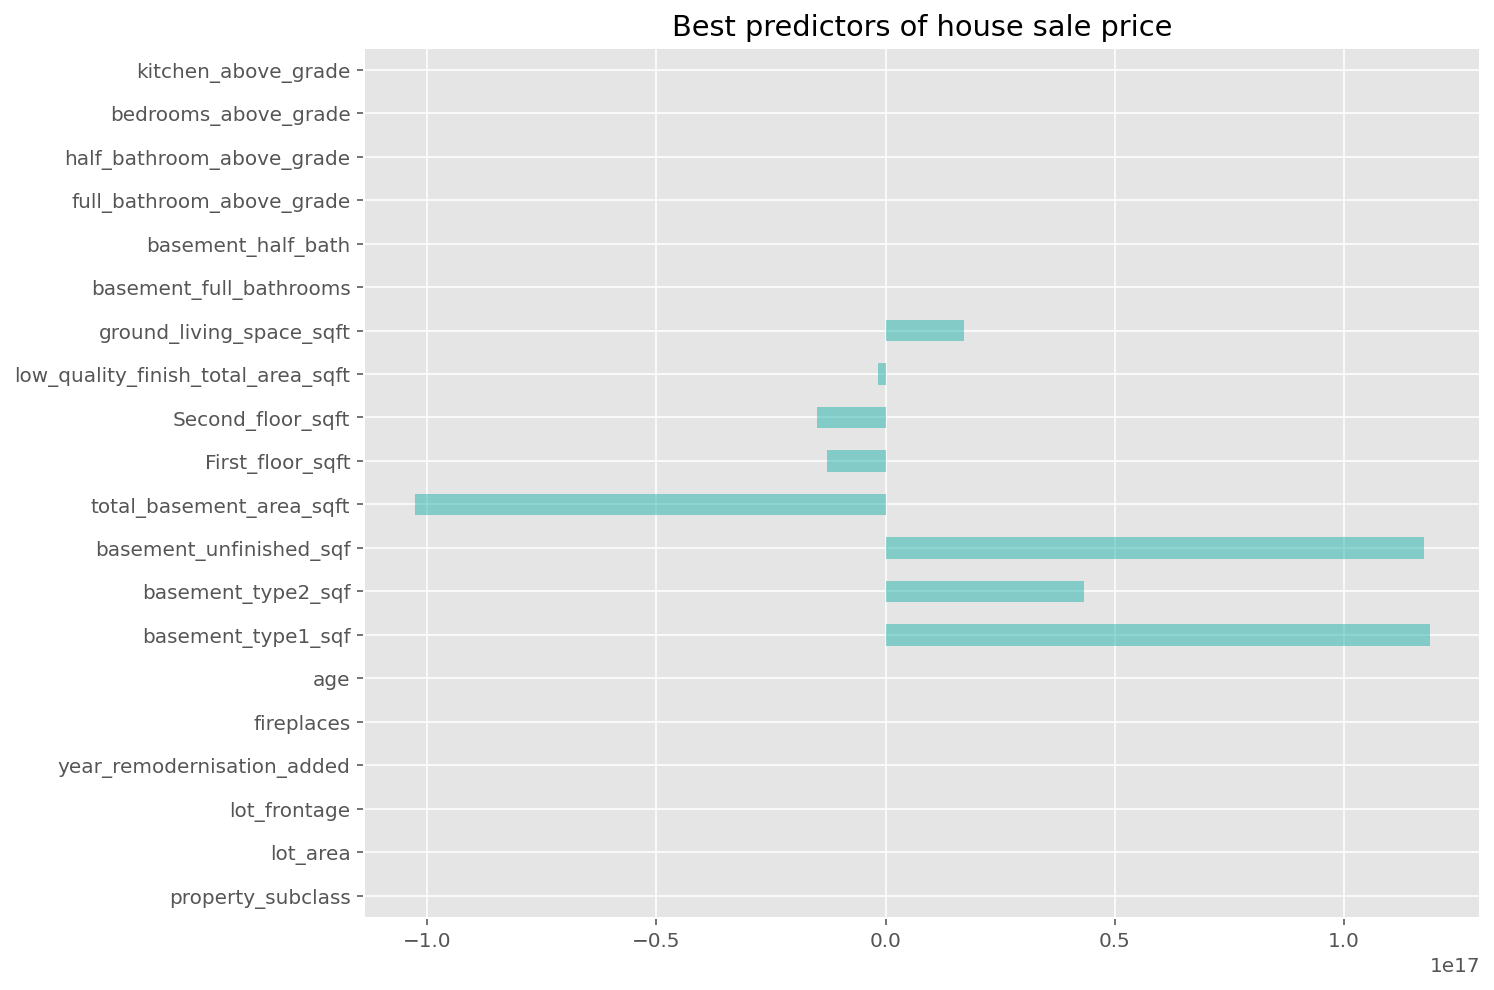

In [23]:
model_fitter(linreg, X_train, y_train, X_test, y_test, cv=5)

# Fitting a RidgeCV model

In [24]:
# creatig a RidgeCV model instance
model_r = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
# fit the model
model_r.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', model_r.alpha_)

Best alpha: 166.81005372000558


Best alpha: 166.81005372000558

Printing model metrics for: Ridge(alpha=166.81005372000558)


Cross-validated training scores: [0.84179501 0.7815098  0.80726681 0.83546573 0.54872717]
Mean cross-validated training score: 0.7629529041628397
R2 Training Score: 0.8505053340631707
R2 Test Score: 0.8400034015995779
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.1
Mean Absolute Error (Σ|y-pred|/n): 16,864
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 23,202
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 22,382


Printing top coefficients:

                                    coefficients     coef_abs
property_subclass                   -2382.028763  2382.028763
lot_area                             2592.394248  2592.394248
lot_frontage                           -1.199475     1.199475
year_remodernisation_added           7234.217028  7234.217028
fireplaces                           4719.381483  4719.381483
age                                 -6281.424775  6281.424775

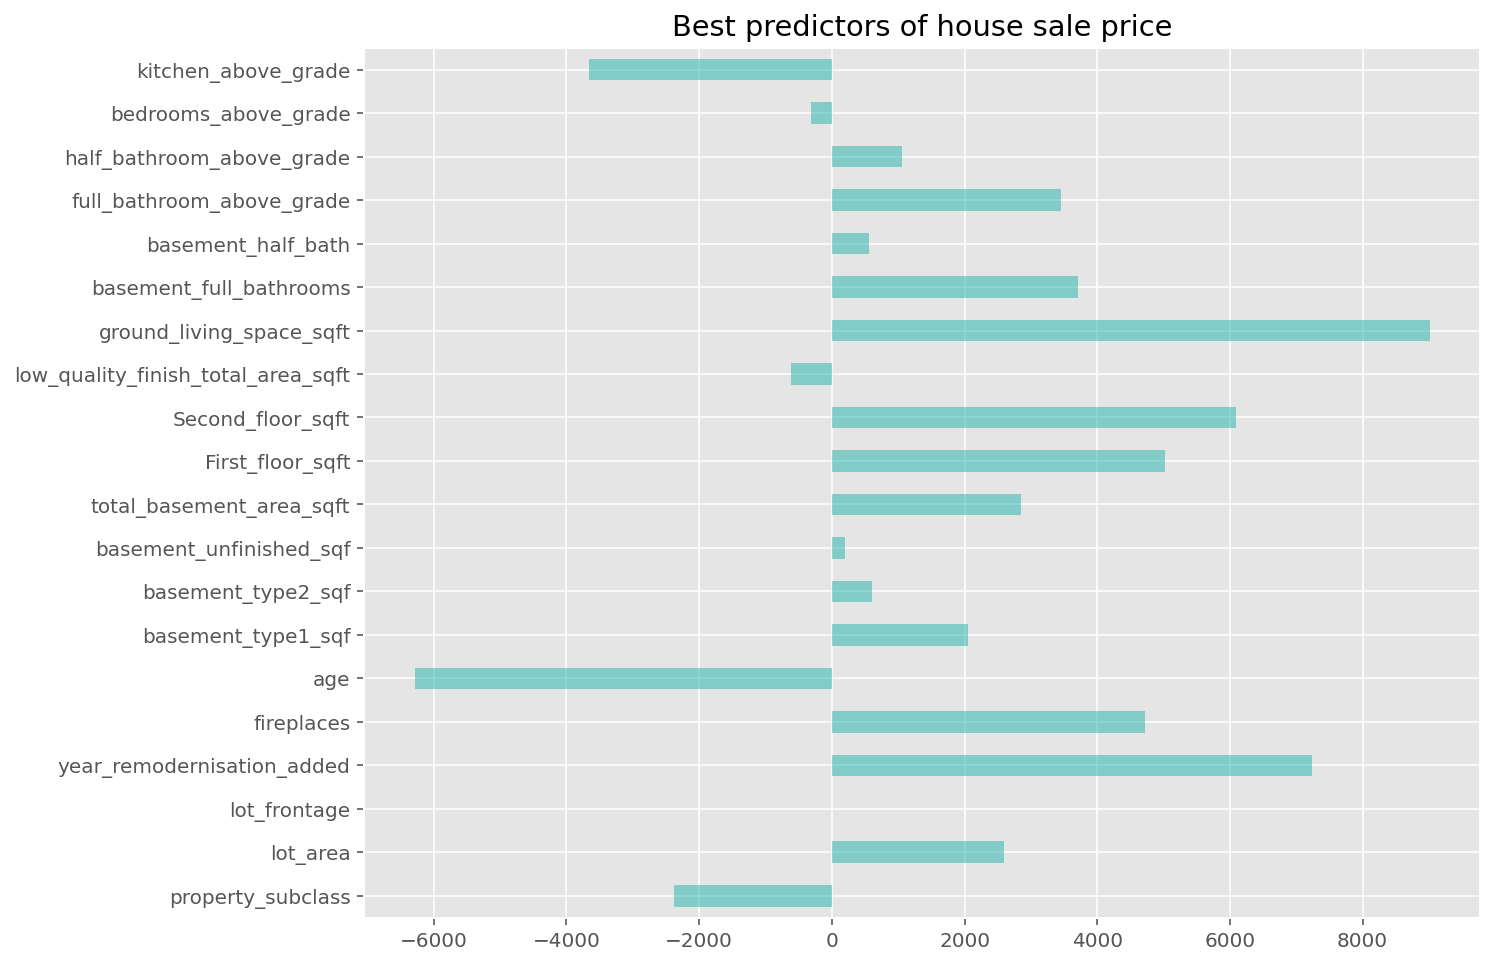

In [25]:
print('Best alpha:', model_r.alpha_)
print()
alpha = model_r.alpha_
# create a Ridge model instance
ridge = Ridge(alpha=alpha)
model_fitter(ridge, X_train, y_train, X_test, y_test, cv=5)


# Fitting a LassoCV model

In [26]:
# create a LassoCV model instance
model_l = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
# fit the model
model_l.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

Best alpha: 1291.5496650148827

Printing model metrics for: Lasso(alpha=1291.5496650148827)


Cross-validated training scores: [0.83783817 0.78720159 0.8093473  0.83177201 0.50369884]
Mean cross-validated training score: 0.7539715813830071
R2 Training Score: 0.8299959064576719
R2 Test Score: 0.8371538411779508
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.1
Mean Absolute Error (Σ|y-pred|/n): 16,989
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 23,407
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 23,868


Printing top coefficients:

                                    coefficients      coef_abs
property_subclass                   -3065.580142   3065.580142
lot_area                             1277.588500   1277.588500
lot_frontage                            0.000000      0.000000
year_remodernisation_added           8252.319431   8252.319431
fireplaces                           5119.069161   5119.069161
age                                 -8578.157961   8578

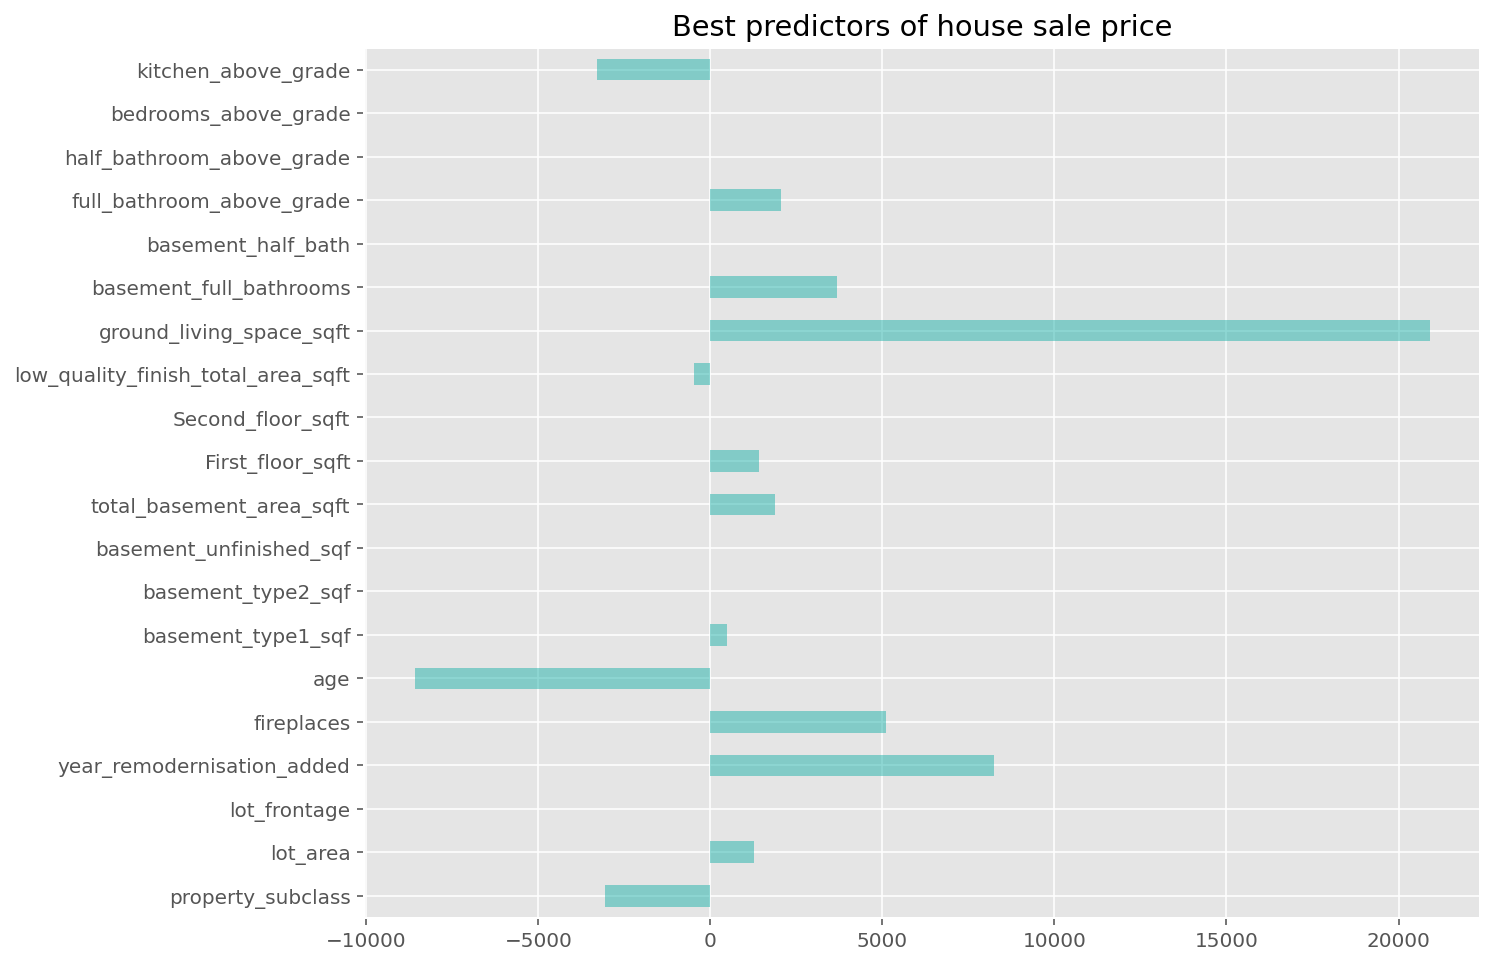

In [27]:
print('Best alpha:', model_l.alpha_)
print()
alpha = model_l.alpha_
# create a Ridge model instance
lasso = Lasso(alpha=alpha)
model_fitter(lasso, X_train, y_train, X_test, y_test, cv=5)


# Fitting an ElasticNetCV model

In [28]:
# create an ElastinNetCV model instance
model_e = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5, max_iter = 100000)
# fit the model
model_e.fit(X_train, y_train)

/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334139627.2089844, tolerance: 317010361.83171225
  model = cd_fast.enet_coordinate_descent_gram(


ElasticNetCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
             cv=5, l1_ratio=array([0.1 , 0.5 , 0.7 , 0.9 , 0.95, 0.99, 1.  ]),
             max_iter=100000)

Best alpha: 0.3593813663804626

Best l1-ratio: 0.1

Printing model metrics for: ElasticNet(alpha=0.3593813663804626, l1_ratio=0.1)


Cross-validated training scores: [0.83669449 0.78381227 0.80545016 0.83379761 0.5814732 ]
Mean cross-validated training score: 0.7682455469494694
R2 Training Score: 0.8411154359853799
R2 Test Score: 0.8369672361812245
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.1
Mean Absolute Error (Σ|y-pred|/n): 16,899
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 23,421
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 23,074


Printing top coefficients:

                                    coefficients     coef_abs
property_subclass                   -1755.513675  1755.513675
lot_area                             2136.269300  2136.269300
lot_frontage                          303.191804   303.191804
year_remodernisation_added           6557.763705  6557.763705
fireplaces                           4669.039967  4669.039967
age                   

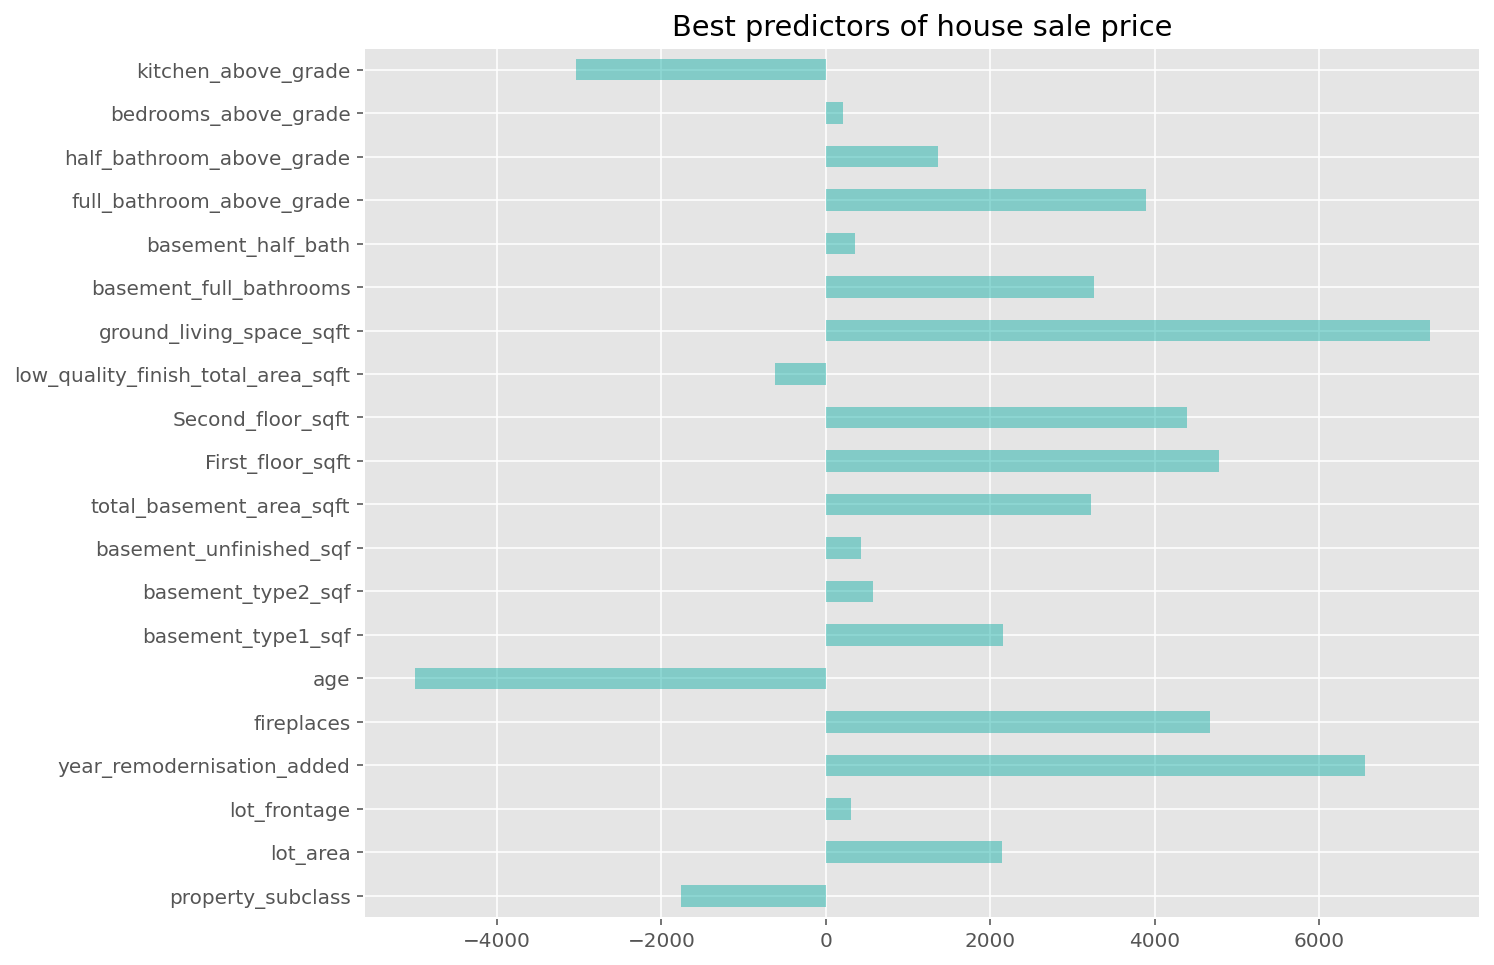

In [29]:
alpha = model_e.alpha_ 
l1_ratio = model_e.l1_ratio_
# get the best alpha
print('Best alpha:', model_e.alpha_)
print()
# get the best l1-ratio
print('Best l1-ratio:', model_e.l1_ratio_)
print()
# create an ElasticNet model instance
elasticnet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
model_fitter(elasticnet, X_train, y_train, X_test, y_test, cv=5)


# Modeling Summary

In [30]:
summary = {'model': ['Linear','Ridge', 'Lasso', 'ElasticNet'],
          'R2_training_score': [linreg.score(X_train, y_train), ridge.score(X_train, y_train), lasso.score(X_train, y_train), elasticnet.score(X_train, y_train)],
          'R2_testing_score': [linreg.score(X_test, y_test), ridge.score(X_test, y_test), lasso.score(X_test, y_test), elasticnet.score(X_test, y_test)],
           'CV_mean_score': [-773828.1303, 0.7630, 0.7540, 0.7682],
           'RMSE in £' : [23501, 23202, 23407, 23421]}
                            

In [31]:
summary = pd.DataFrame.from_dict(summary)

summary.round(decimals=4)

model  R2_training_score  R2_testing_score  CV_mean_score  RMSE in £
0      Linear             0.8579            0.8359   -773828.1303      23501
1       Ridge             0.8505            0.8400         0.7630      23202
2       Lasso             0.8300            0.8372         0.7540      23407
3  ElasticNet             0.8411            0.8370         0.7682      23421

Having used Linear Regression, Ridge, Lasso and Elastic Net, Linear Regression performed the worst amongs all of the models. Train and Test scores are encouraging, however cross-validation scores clearly show the model is not performing best. Perhaps it cannot hanndle so many features, as well as multicollinearity between the predictors may affect the results too.

With respect to the coefficients interestingly Ridge, Lasso and Elastic net yield similar features as the strongest predictors of the house sale price. Age, kitchen quality being among the most negatively impacting on sale price and ground living square foot, first floor square foot and year remodernisation added being amongs the most positively influencing the sale price. The monetary value of the coeficients will be explained in the summary secion below, after performing residual analysis. 

Rigde, Lasso and Elastic net preformed roughly the same, but based on RMSE result further analysis was perfomred performed using Ridge model, since it yield the lowest RMSE. 

Ridge result shows on average, the predictions have an error of 16,864 USD - mean absolute error, or in other words predictions are wrong  by 10 percent  - this is information is obtained from mean absolute percentage error. 
Looking at the RMSE, which is square root of the average squared difference between the predicted values and the actual values in a dataset. In case of Rigde, 23,202 were obtained in terms of USD.




## RESIDUALS ANALYSIS

In [32]:
#Ridge predictions and residuals for train and test sets
predicted_test = ridge.predict(X_test)
predicted_train = ridge.predict(X_train)
residual_test = y_test - predicted_test
residual_train = y_train - predicted_train


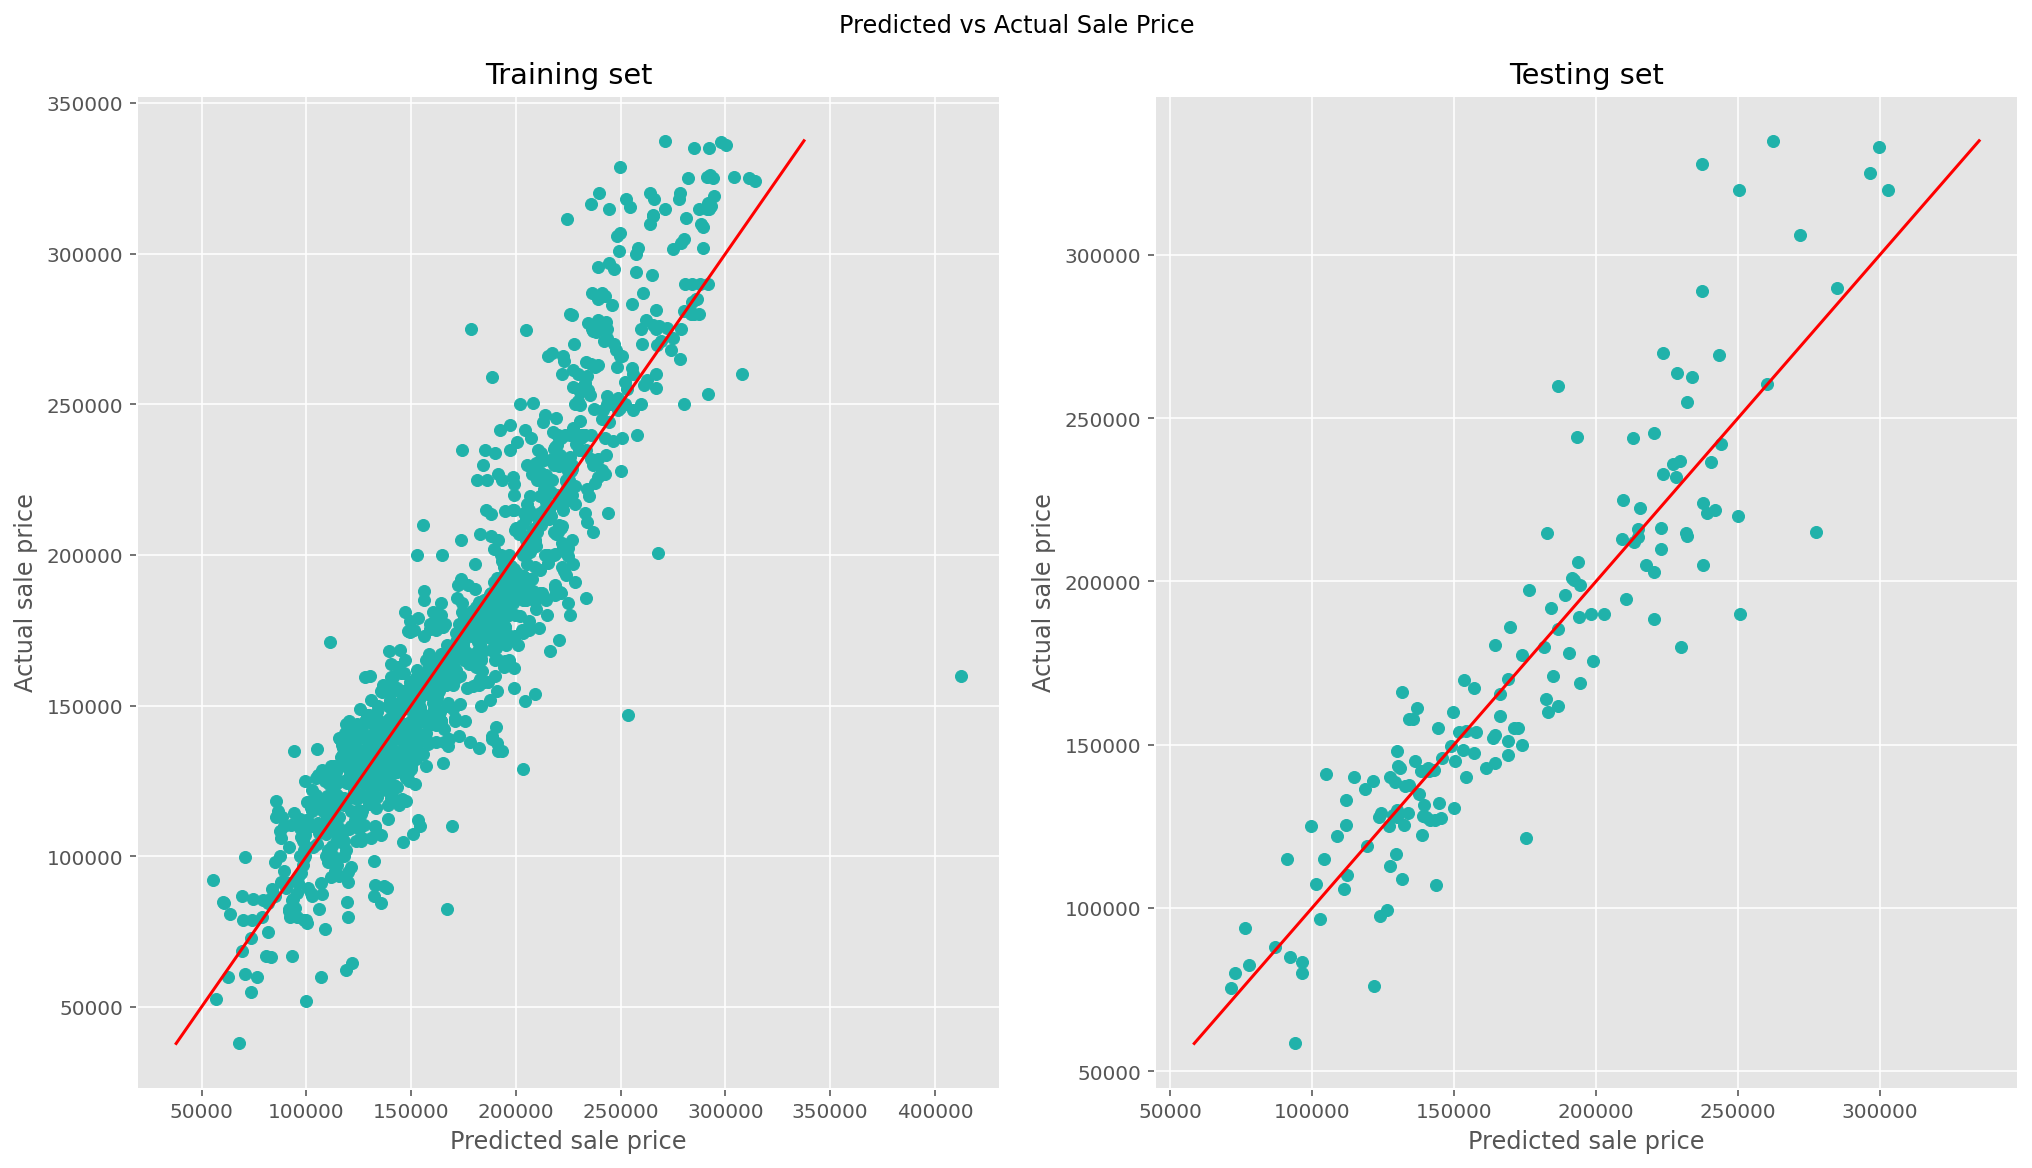

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8), constrained_layout=True)

fig.suptitle('Predicted vs Actual Sale Price')
ax[0].scatter(predicted_train,y_train,  color = 'lightseagreen')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r')
ax[0].set_ylabel('Actual sale price')
ax[0].set_xlabel('Predicted sale price')
ax[0].set_title('Training set')

ax[1].scatter(predicted_test,y_test, color = 'lightseagreen')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
ax[1].set_ylabel('Actual sale price')
ax[1].set_xlabel('Predicted sale price')
ax[1].set_title('Testing set');

Looking at the predicted vs actual sale price scatterplot, it is very obvious, that the price prediction of one of the property in the train set was way over the top. This house was investigated further below. Remaining of the data points both in train and test set, are centered around line of best fit, which suggests the model works well.  
I will look at the distribution of the residuals as well as apply stats models first, and then decide whenever I will remove the sigle property out or not. 

In [34]:
pred_train = pd.DataFrame(predicted_train)
pred_train.idxmax()

0    1051
dtype: int64

In [35]:
pred_train.loc[1051]

0    412458.904904
Name: 1051, dtype: float64

In [36]:
pred_train.shape

(1185, 1)

In [37]:
y_train.shape

(1185,)

In [38]:
y_train.loc[1192]

160000

In [39]:
X_train.loc[1051]

property_subclass                      0.061147
lot_area                               6.118663
lot_frontage                           7.458443
year_remodernisation_added             1.147515
fireplaces                             3.835900
age                                   -1.217934
basement_type1_sqf                    12.030282
basement_type2_sqf                    -0.291398
basement_unfinished_sqf               -0.260774
total_basement_area_sqft              13.488821
First_floor_sqft                       9.936595
Second_floor_sqft                      1.438256
low_quality_finish_total_area_sqft    -0.123554
ground_living_space_sqft               8.639861
basement_full_bathrooms                3.085235
basement_half_bath                    -0.258445
full_bathroom_above_grade              0.857759
half_bathroom_above_grade              1.223974
bedrooms_above_grade                   0.171921
kitchen_above_grade                   -0.183790
total_rooms_above_grade                3

In [40]:
house.loc[1192]

id                                           1299
property_subclass                              60
property_zoning                                RL
lot_frontage                                313.0
lot_area                                    63887
street                                       Pave
alley                                         NaN
lot_shape                                     IR3
land_contour                                  Bnk
utilities                                  AllPub
lot_config                                 Corner
land_slope                                    Gtl
neighbourhood                             Edwards
condition_1                                 Feedr
condition_2                                  Norm
property_type                                1Fam
house_style                                2Story
overall_quality                                10
overall_condition                               5
year_built                                   2008


## RESIDUAL ANALYSIS USING STATS MODEL

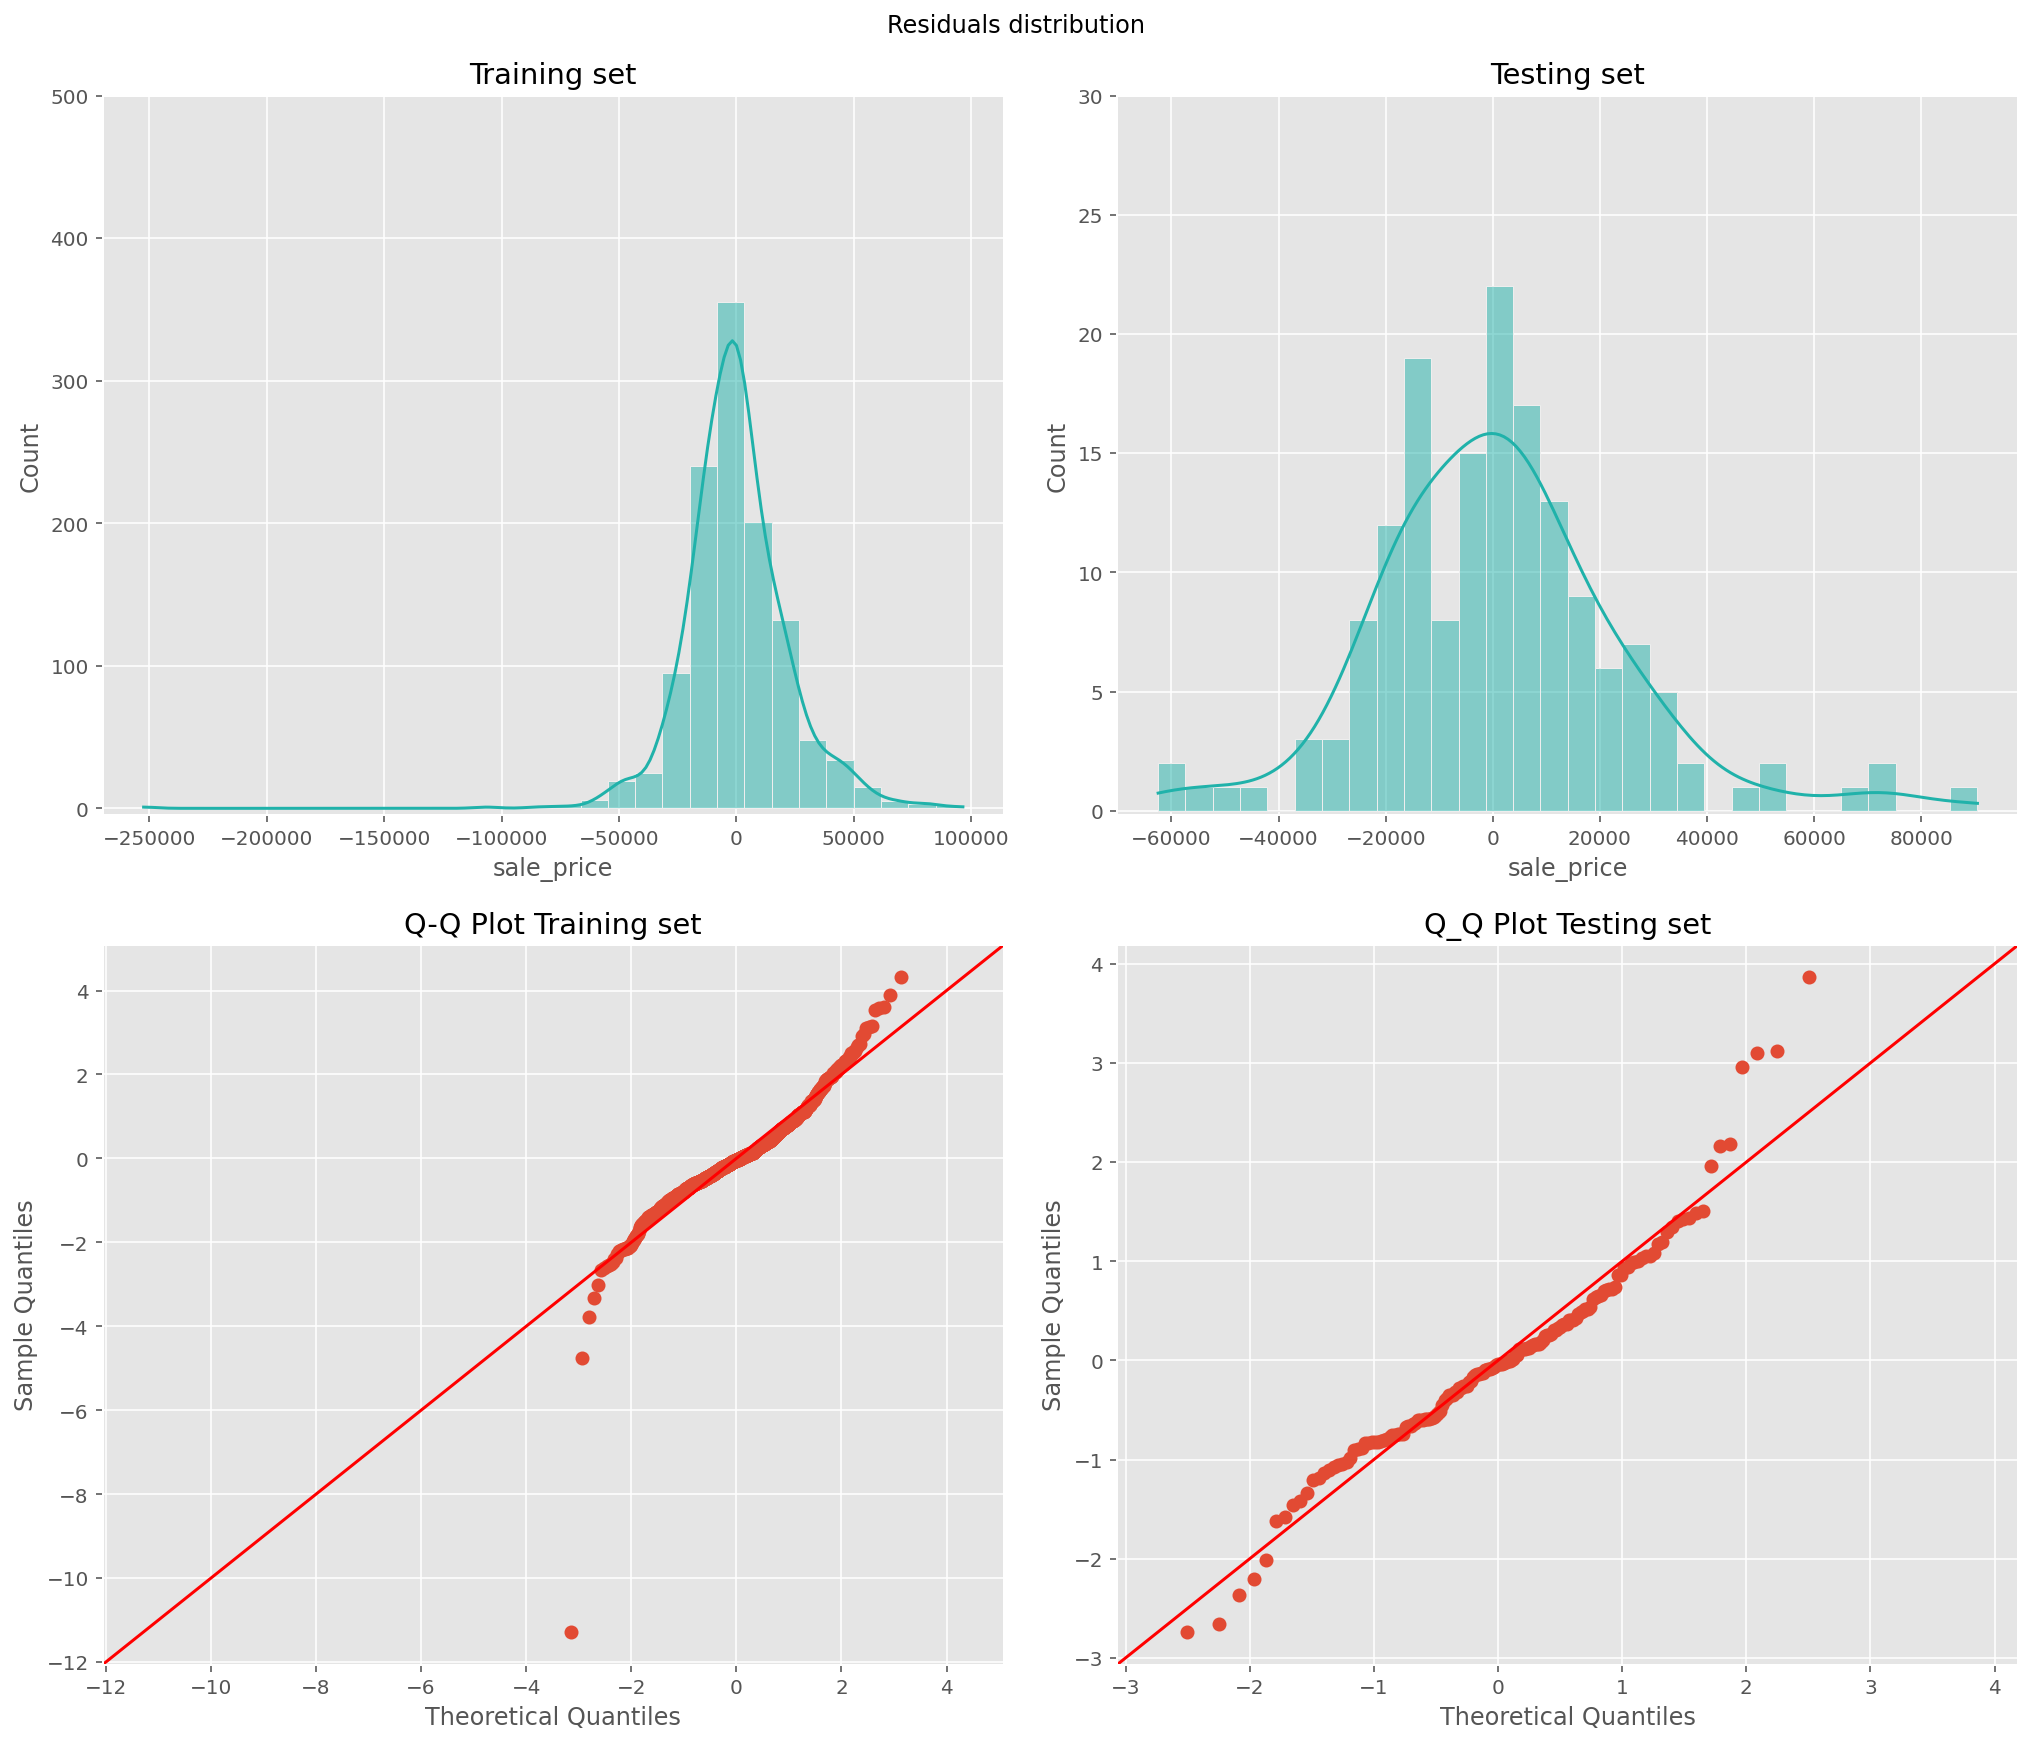

In [41]:
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(ncols=2,nrows =2, figsize=(14, 12), constrained_layout=True)

fig.suptitle('Residuals distribution')
sns.histplot(data=residual_train , bins=30, ax = ax[0,0], kde = True, alpha=.5, color = 'lightseagreen')
ax[0,0].set_ylim(-5,500)
ax[0,0].set_title('Training set')

sns.histplot(data=residual_test , bins=30, ax = ax[0,1], kde = True, alpha=.5, color = 'lightseagreen')
ax[0,1].set_ylim(-0.2,30)
ax[0,1].set_title('Testing set')


qqplot(np.array(residual_train), line='45', fit=True, ax = ax[1,0])
ax[1,0].set_title('Q-Q Plot Training set')

qqplot(np.array(residual_test), line='45', fit=True, ax = ax[1,1])
ax[1,1].set_title('Q_Q Plot Testing set');


Looking at the residuals distribution and qq plots, it is clear that distribution is skewed to the left, with lower end creating longer tail as data point deviates from the straight line a lot. 
Test set residuals and qq plot on the other hand, shows more stabilized distribution. Majority of the residuals fall within normal distribution, withh the slight right skew, also seen on the qq plot as the upper end deviates from the straight line slightly. 

Since the goal is to work with normally distributed residuals, especially that they will be used in further modelling, it seems like the property with highly overpriced prediction above might be dropped. Lets lok at stats and look at residuals distribution using log of sale first.

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [43]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     65.67
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        05:07:14   Log-Likelihood:                -15359.
No. Observations:                1346   AIC:                         3.095e+04
Df Residuals:                    1232   BIC:                         3.154e+04
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -6.515e+05   9.18e+04     -7.096      0.000   -8.32e+05   -4.71e+05
property_subclass                    -53.8787     78.832     -0.683      0.494    -208.538     100.780
lot_area                               0.3633      0.116      3.138      0.002       0.136       0.590
lot_frontage                           1.8269     22.285      0.082      0.935     -41.893      45.547
year_remodernisation_added           337.2602     44.125      7.643      0.000     250.691     423.829
fireplaces                          6658.6710   1307.671      5.092      0.000    4093.162    9224.180
age                                 -351.1962     62.108     -5.655      0.000    -473.045    -229.348
basement_type1_sqf                     5.7786      1.980      2.919      0.004       1.894       9.663
basement_type2_sqf                     2.4390      3.274      0.745      0.456      -3.984       8.862
basement_unfinished_sqf               -0.0398      1.975     -0.020      0.984      -3.915       3.836
total_basement_area_sqft               8.1779      3.421      2.390      0.017       1.466      14.890
First_floor_sqft                       8.6276      6.013      1.435      0.152      -3.170      20.425
Second_floor_sqft                     29.7696      5.359      5.555      0.000      19.255      40.284
low_quality_finish_total_area_sqft    -6.6106     13.180     -0.502      0.616     -32.468      19.247
ground_living_space_sqft              31.7866      5.295      6.003      0.000      21.398      42.175
basement_full_bathrooms             8233.9503   1847.383      4.457      0.000    4609.586    1.19e+04
basement_half_bath                  2682.8922   2873.401      0.934      0.351   -2954.409    8320.193
full_bathroom_above_grade           2681.5631   2159.526      1.242      0.215   -1555.192    6918.318
half_bathroom_above_grade          -1026.3982   2057.354     -0.499      0.618   -5062.704    3009.907
bedrooms_above_grade               -2160.6628   1329.297     -1.625      0.104   -4768.599     447.274
kitchen_above_grade                -2.146e+04   5324.990     -4.029      0.000   -3.19e+04    -1.1e+04
total_rooms_above_grade             1875.3729    956.298      1.961      0.050      -0.780    3751.525
garage_cars_capacity                1.137e+04   2147.525      5.295      0.000    7158.570    1.56e+04
garage_sqft_area                      -5.5952      7.604     -0.736      0.462     -20.514       9.324
wood_deck_area_sqft                   21.0838      5.783      3.646      0.000       9.738      32.429
open_porch_area_sqft                  26.8461     11.482      2.338      0.020       4.320      49.372
enclosed_porch_area_sqft              25.4852     12.154      2.097      0.036       1.640      

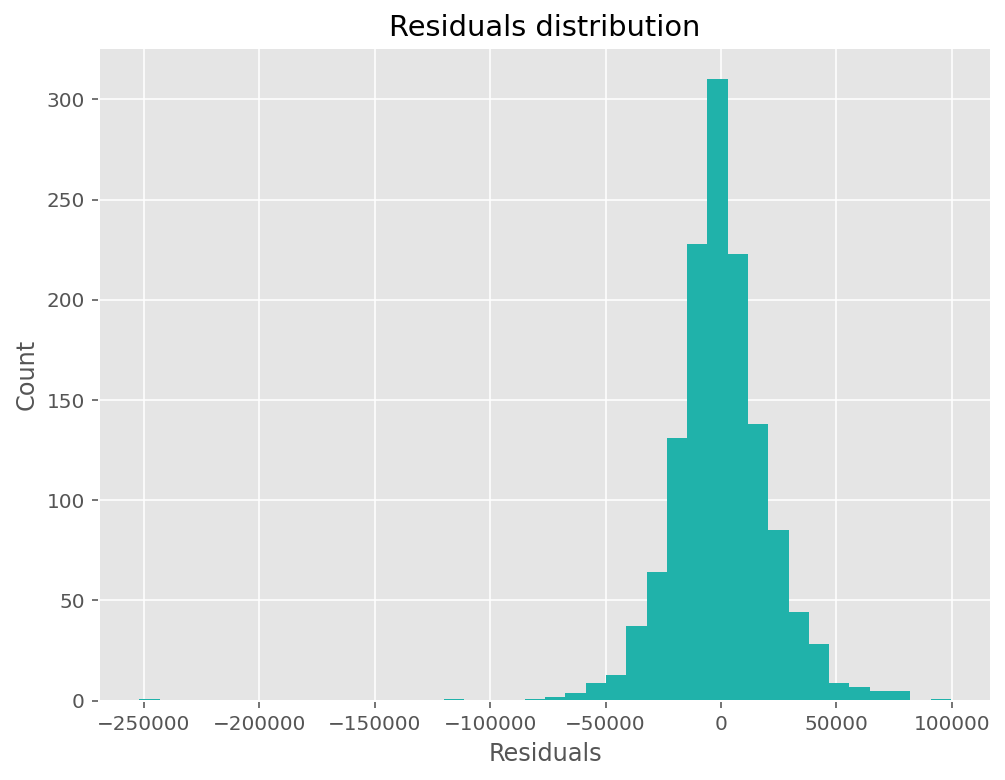

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(results.resid, bins=40, color = 'lightseagreen')
plt.title('Residuals distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.show()

In [45]:
#regularized with Ridge penalty
results_reg = model.fit_regularized(alpha= 0.01, L1_wt =0.5, refit=True)

In [46]:
results_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     63.87
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        05:07:16   Log-Likelihood:                -15359.
No. Observations:                1346   AIC:                         3.095e+04
Df Residuals:                    1230   BIC:                         3.156e+04
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -6.515e+05   9.19e+04     -7.091      0.000   -8.32e+05   -4.71e+05
property_subclass                    -53.8787     78.896     -0.683      0.495    -208.664     100.906
lot_area                               0.3633      0.116      3.135      0.002       0.136       0.591
lot_frontage                           1.8269     22.303      0.082      0.935     -41.929      45.583
year_remodernisation_added           337.2602     44.161      7.637      0.000     250.621     423.900
fireplaces                          6658.6710   1308.734      5.088      0.000    4091.073    9226.269
age                                 -351.1962     62.158     -5.650      0.000    -473.144    -229.249
basement_type1_sqf                     5.7786      1.981      2.916      0.004       1.891       9.666
basement_type2_sqf                     2.4390      3.277      0.744      0.457      -3.989       8.867
basement_unfinished_sqf               -0.0398      1.977     -0.020      0.984      -3.919       3.839
total_basement_area_sqft               8.1779      3.424      2.388      0.017       1.461      14.895
First_floor_sqft                       8.6276      6.018      1.434      0.152      -3.179      20.435
Second_floor_sqft                     29.7696      5.364      5.550      0.000      19.246      40.293
low_quality_finish_total_area_sqft    -6.6106     13.191     -0.501      0.616     -32.489      19.268
ground_living_space_sqft              31.7866      5.300      5.998      0.000      21.389      42.184
basement_full_bathrooms             8233.9503   1848.884      4.453      0.000    4606.635    1.19e+04
basement_half_bath                  2682.8922   2875.736      0.933      0.351   -2958.999    8324.783
full_bathroom_above_grade           2681.5631   2161.281      1.241      0.215   -1558.642    6921.768
half_bathroom_above_grade          -1026.3982   2059.026     -0.498      0.618   -5065.991    3013.194
bedrooms_above_grade               -2160.6628   1330.377     -1.624      0.105   -4770.723     449.397
kitchen_above_grade                -2.146e+04   5329.318     -4.026      0.000   -3.19e+04    -1.1e+04
total_rooms_above_grade             1875.3729    957.075      1.959      0.050      -2.307    3753.053
garage_cars_capacity                1.137e+04   2149.270      5.291      0.000    7155.140    1.56e+04
garage_sqft_area                      -5.5952      7.610     -0.735      0.462     -20.526       9.336
wood_deck_area_sqft                   21.0838      5.788      3.643      0.000       9.729      32.439
open_porch_area_sqft                  26.8461     11.491      2.336      0.020       4.302      49.390
enclosed_porch_area_sqft              25.4852     12.164      2.095      0.036       1.621      

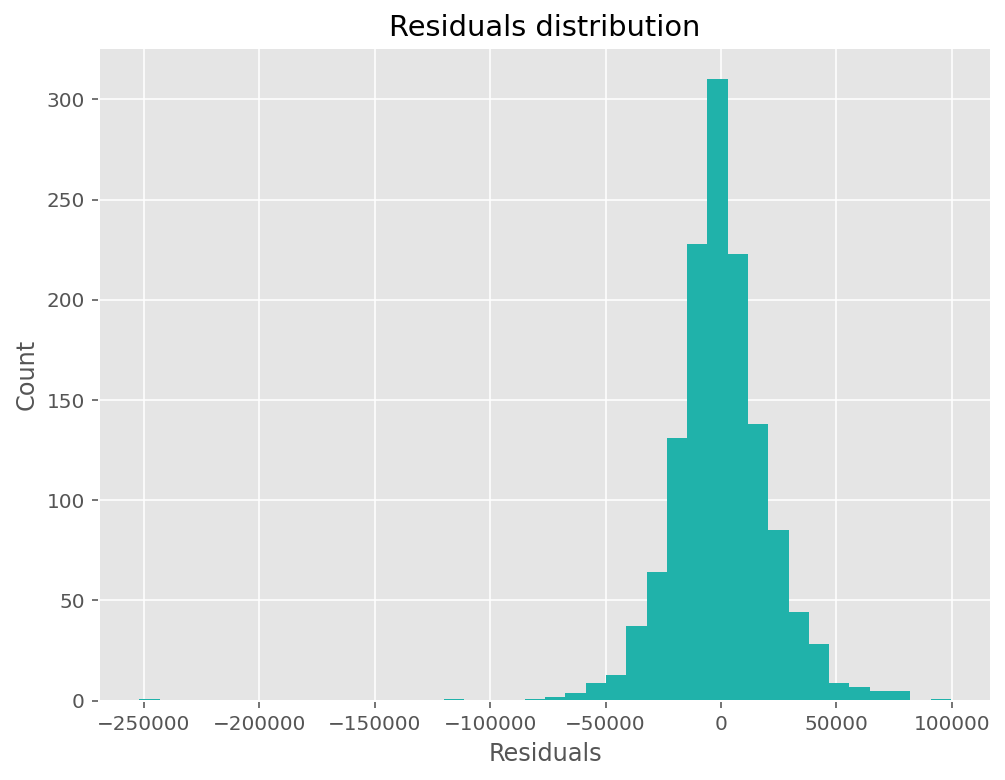

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(results_reg.resid, bins=40, color = 'lightseagreen')
plt.title('Residuals distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.show()

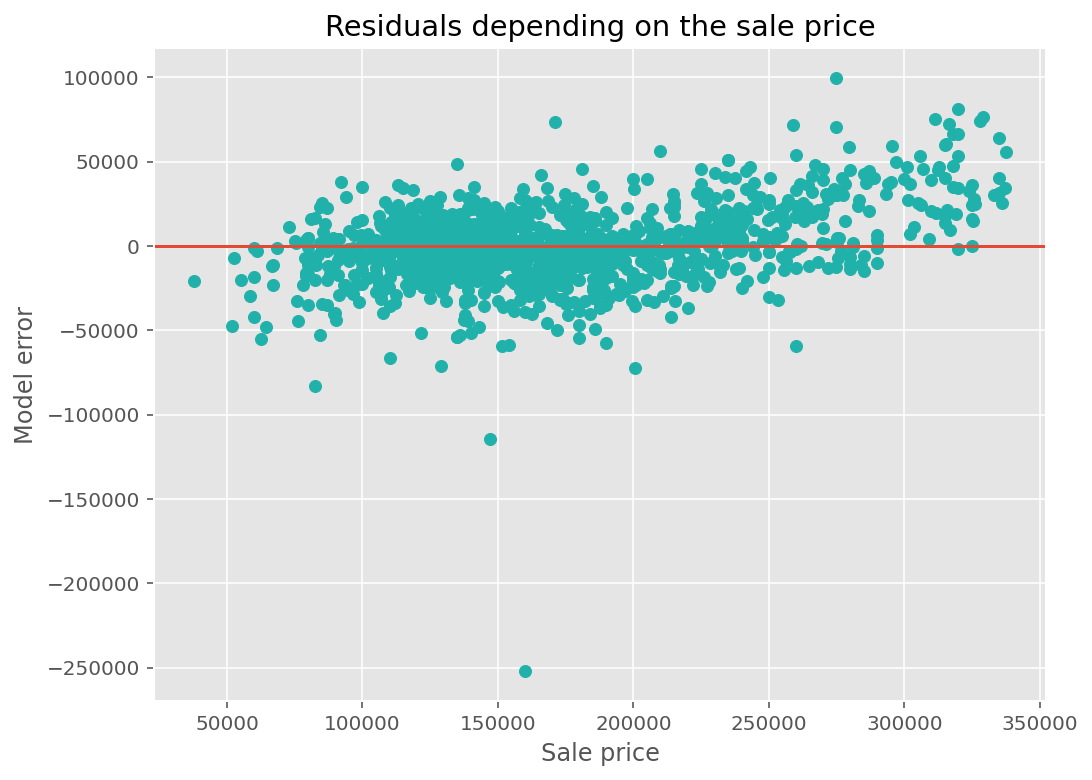

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(y, results.resid, color = 'lightseagreen')
plt.axhline(0)
plt.title("Residuals depending on the sale price")
plt.xlabel("Sale price")
plt.ylabel("Model error")
plt.show()

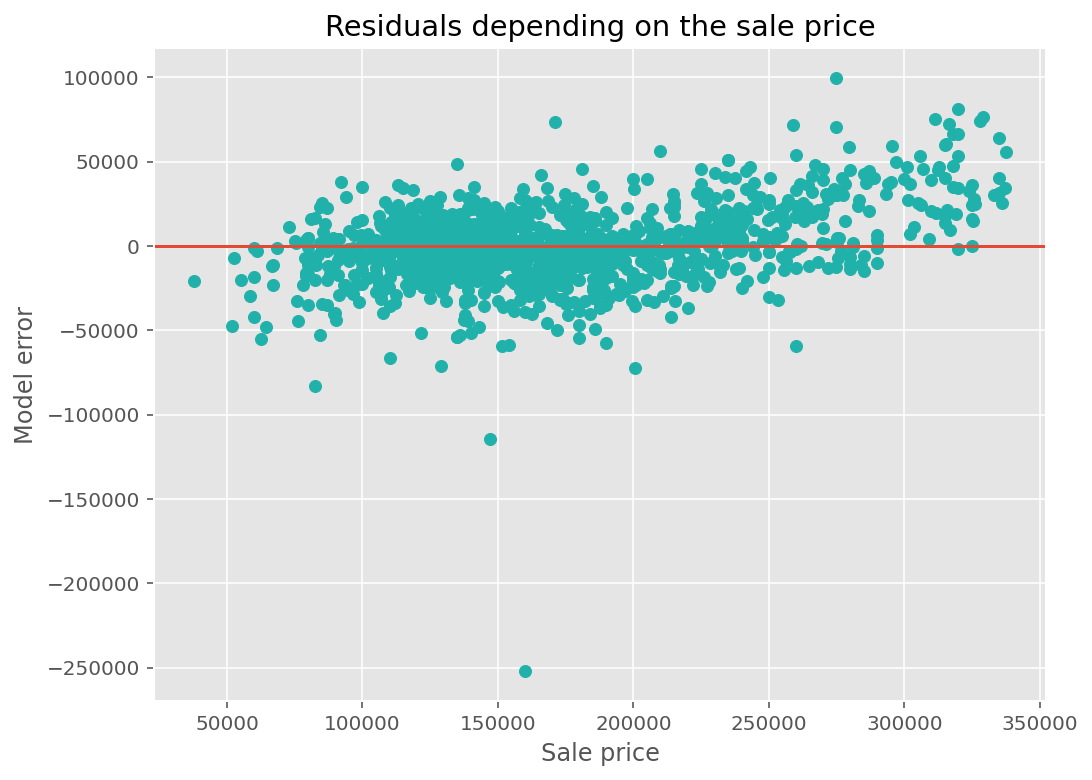

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(y, results_reg.resid, color = 'lightseagreen')
plt.axhline(0)
plt.title("Residuals depending on the sale price")
plt.xlabel("Sale price")
plt.ylabel("Model error")
plt.show()

In [50]:
X.head()

property_subclass  lot_area  lot_frontage  year_remodernisation_added  \
0                 60      8450          65.0                        2003   
1                 20      9600          80.0                        1976   
2                 60     11250          68.0                        2002   
3                 70      9550          60.0                        1970   
4                 60     14260          84.0                        2000   

   fireplaces  age  basement_type1_sqf  basement_type2_sqf  \
0           0    5                 706                   0   
1           1   31                 978                   0   
2           1    7                 486                   0   
3           1   91                 216                   0   
4           1    8                 655                   0   

   basement_unfinished_sqf  total_basement_area_sqft  First_floor_sqft  \
0                      150                       856               856   
1                      284                      1262              1262   
2                      434                       920               920   
3                      540                       756               961   
4                      490                      1145              1145   

   Second_floor_sqft  low_quality_finish_total_area_sqft  \
0                854                                   0   
1                  0                                   0   
2                866                                   0   
3                756                                   0   
4               1053                                   0   

   ground_living_space_sqft  basement_full_bathrooms  basement_half_bath  \
0                      1710                        1                   0   
1                      1262                        0                   1   
2                      1786                        1                   0   
3                      1717                        1                   0   
4                      2198                        1                   0   

   full_bathroom_above_grade  half_bathroom_above_grade  bedrooms_above_grade  \
0                          2                          1                     3   
1                          2                          0                     3   
2                          2                          1                     3   
3                          1                          0                     3   
4                          2                          1                     4   

   kitchen_above_grade  total_rooms_above_grade  garage_cars_capacity  \
0                    1                        8                     2   
1                    1                        6                     2   
2                    1                        6                     2   
3                    1                        7                     3   
4                    1                        9                     3   

   garage_sqft_area  wood_deck_area_sqft  open_porch_area_sqft  \
0               548                    0                    61   
1               460                  298                     0   
2               608                    0                    42   
3               642                    0                    35   
4               836                  192                    84   

   enclosed_porch_area_sqft  Three_seasons_porch_area_sqft  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                       272                              0   
4                         0                              0   

   screen_porch_area_sqft  has_pool  masonry_veneer_area  property_zoning_RH  \
0                       0         0                196.0                   0   
1                       0         0                  0

In [51]:
import warnings
warnings.simplefilter('ignore')

In [52]:
X['abs_error'] = abs(results.resid)
X['error'] = results.resid
X['sale_price'] = y
X['sale_price_pred'] = results.predict()
sorted_columns = X.columns
X.sort_values('abs_error', ascending=False).head(5)[sorted_columns].round(2)

property_subclass  lot_area  lot_frontage  year_remodernisation_added  \
1192                 60     63887         313.0                        2008   
1217                 20      9986          75.0                        2007   
1310                 80     19690           0.0                        1966   
580                  20     11900          85.0                        1977   
659                  20     13286          86.0                        2008   

      fireplaces  age  basement_type1_sqf  basement_type2_sqf  \
1192           3    0                5644                   0   
1217           1    1                   0                   0   
1310           1   40                   0                   0   
580            1   32                 822                   0   
659            1    2                1234                   0   

      basement_unfinished_sqf  total_basement_area_sqft  First_floor_sqft  \
1192                      466                      6110              4692   
1217                     1795                      1795              1795   
1310                      697                       697              1575   
580                       564                      1386              1411   
659                       464                      1698              1698   

      Second_floor_sqft  low_quality_finish_total_area_sqft  \
1192                950                                   0   
1217                  0                                   0   
1310                626                                   0   
580                   0                                   0   
659                   0                                   0   

      ground_living_space_sqft  basement_full_bathrooms  basement_half_bath  \
1192                      5642                        2                   0   
1217                      1795                        0                   0   
1310                      2201                        0                   0   
580                       1411                        0                   0   
659                       1698                        1                   0   

      full_bathroom_above_grade  half_bathroom_above_grade  \
1192                          2                          1   
1217                          2                          0   
1310                          2                          0   
580                           2                          0   
659                           2                          0   

      bedrooms_above_grade  kitchen_above_grade  total_rooms_above_grade  \
1192                     3                    1                       12   
1217                     2                    1                        7   
1310                     4                    1                        8   
580                      3                    1                        6   
659                      3                    1                        8   

      garage_cars_capacity  garage_sqft_area  wood_deck_area_sqft  \
1192                     2              1418                  214   
1217                     3               895                    0   
1310                     2               432                  586   
580                      2               544                  192   
659                      3               768                  327   

      open_porch_area_sqft  enclosed_porch_area_sqft  \
1192                   292                         0   
1217                    49                         0   
1310                   236                         0   
580                      0                         0   
659                     64                         0   

      Three_seasons_porch_area_sqft  screen_porch_area_sqft  has_pool  \
1192                              0                       0         1   
1217                              0                       0         0   
1310                  

In [53]:
# Looking for highest error
X.loc[X['sale_price_pred']==X['sale_price_pred'].max()]

property_subclass  lot_area  lot_frontage  year_remodernisation_added  \
1192                 60     63887         313.0                        2008   

      fireplaces  age  basement_type1_sqf  basement_type2_sqf  \
1192           3    0                5644                   0   

      basement_unfinished_sqf  total_basement_area_sqft  First_floor_sqft  \
1192                      466                      6110              4692   

      Second_floor_sqft  low_quality_finish_total_area_sqft  \
1192                950                                   0   

      ground_living_space_sqft  basement_full_bathrooms  basement_half_bath  \
1192                      5642                        2                   0   

      full_bathroom_above_grade  half_bathroom_above_grade  \
1192                          2                          1   

      bedrooms_above_grade  kitchen_above_grade  total_rooms_above_grade  \
1192                     3                    1                       12   

      garage_cars_capacity  garage_sqft_area  wood_deck_area_sqft  \
1192                     2              1418                  214   

      open_porch_area_sqft  enclosed_porch_area_sqft  \
1192                   292                         0   

      Three_seasons_porch_area_sqft  screen_porch_area_sqft  has_pool  \
1192                              0                       0         1   

      masonry_veneer_area  property_zoning_RH  property_zoning_RL  \
1192                796.0                   0                   1   

      property_zoning_RM  street_Pave  lot_shape_IR2  lot_shape_IR3  \
1192                   0            1              0              1   

      lot_shape_Reg  land_contour_HLS  land_contour_Low  land_contour_Lvl  \
1192              0                 0                 0                 0   

      lot_config_CulDSac  lot_config_FR2  lot_config_FR3  lot_config_Inside  \
1192                   0               0               0                  0   

      land_slope_Mod  land_slope_Sev  neighbourhood_Blueste  \
1192               0               0                      0   

      neighbourhood_BrDale  neighbourhood_BrkSide  neighbourhood_ClearCr  \
1192                     0                      0                      0   

      neighbourhood_CollgCr  neighbourhood_Crawfor  neighbourhood_Edwards  \
1192                      0                      0                      1   

      neighbourhood_Gilbert  neighbourhood_IDOTRR  neighbourhood_MeadowV  \
1192                      0                     0                      0   

      neighbourhood_Mitchel  neighbourhood_NAmes  neighbourhood_NPkVill  \
1192                      0                    0                      0   

      neighbourhood_NWAmes  neighbourhood_NoRidge  neighbourhood_NridgHt  \
1192                     0                      0                      0   

      neighbourhood_OldTown  neighbourhood_SWISU  neighbourhood_Sawyer  \
1192                      0                    0                     0   

      neighbourhood_SawyerW  neighbourhood_Somerst  neighbourhood_StoneBr  \
1192                      0                      0                      0   

      neighbourhood_Timber  neighbourhood_Veenker  condition_1_Feedr  \
1192                     0                      0                  1   

      condition_1_Norm  condition_1_PosA  condition_1_PosN  condition_1_RRAe  \
1192                 0                 0                 0                 0   

      condition_1_RRAn  condition_1_RRNe  condition_1_RRNn  condition_2_Feedr  \
1192                 0                 0                 0                  0   

      condition_2_Norm  condition_2_PosA  condition_2_PosN  condition_2_RRAe  \
1192                 1                 0                 0                 0   

      condition_2_RRAn  condition_2_RRNn  property_type_2fmCon  \
1192                 0                 0                     0   

      property_type_Duplex  property_type_T

In [54]:
X.sort_values('abs_error').head()[sorted_columns].round(2)

property_subclass  lot_area  lot_frontage  year_remodernisation_added  \
1129                 90     18890           0.0                        1977   
918                  90     11500           0.0                        1976   
534                  75     13500          75.0                        2000   
479                  60     40094         130.0                        2008   
1266                 20     10991          89.0                        2007   

      fireplaces  age  basement_type1_sqf  basement_type2_sqf  \
1129           1   30                 498                 211   
918            0   31                   0                   0   
534            1  115                   0                   0   
479            1    0                2260                   0   
1266           1    0                   0                   0   

      basement_unfinished_sqf  total_basement_area_sqft  First_floor_sqft  \
1129                      652                      1361              1361   
918                      1680                      1680              1680   
534                      1237                      1237              1521   
479                       878                      3138              3138   
1266                     1571                      1571              1571   

      Second_floor_sqft  low_quality_finish_total_area_sqft  \
1129               1259                                   0   
918                   0                                   0   
534                1254                                   0   
479                1538                                   0   
1266                  0                                   0   

      ground_living_space_sqft  basement_full_bathrooms  basement_half_bath  \
1129                      2620                        0                   0   
918                       1680                        0                   0   
534                       2775                        0                   0   
479                       4676                        1                   0   
1266                      1571                        0                   0   

      full_bathroom_above_grade  half_bathroom_above_grade  \
1129                          2                          2   
918                           2                          0   
534                           3                          1   
479                           3                          1   
1266                          2                          0   

      bedrooms_above_grade  kitchen_above_grade  total_rooms_above_grade  \
1129                     4                    2                       12   
918                      4                    2                        8   
534                      3                    1                        9   
479                      3                    1                       11   
1266                     3                    1                        7   

      garage_cars_capacity  garage_sqft_area  wood_deck_area_sqft  \
1129                     2               600                  155   
918                      2               528                    0   
534                      2               880                  105   
479                      3               884                  208   
1266                     3               722                  100   

      open_porch_area_sqft  enclosed_porch_area_sqft  \
1129                    24                       145   
918                      0                         0   
534                    502                         0   
479                    406                         0   
1266                    36                         0   

      Three_seasons_porch_area_sqft  screen_porch_area_sqft  has_pool  \
1129                              0                       0         0   
918                               0                       0         0   
534                   

In [55]:
X_plot = X[['error', 'sale_price', 'sale_price_pred']].copy()

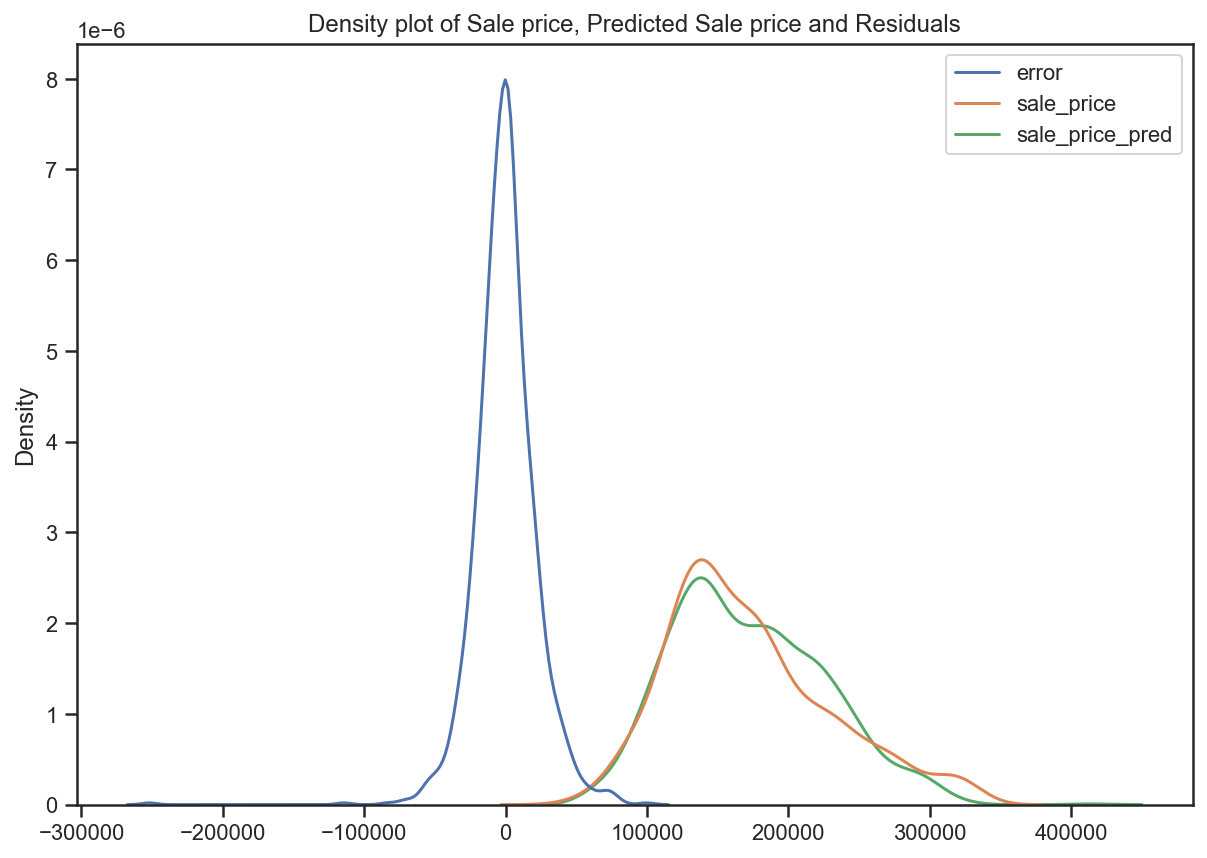

In [56]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(10, 7))
sns.kdeplot(data = X_plot, legend = True)
# sns.kdeplot(X['sale_price'], legend = True)
# sns.kdeplot(X['sale_price_pred'], legend = True)
ax.set_title('Density plot of Sale price, Predicted Sale price and Residuals')
plt.show()

Using stats models, property with the highest error was identified - which turn out to be property predicted 251999.360492 USD above the actual price. Same property was identified as with Ridge residual analysis. 

Applying OLS to the whole data usisng stats models allowed to look at the statistical significance of each of the predictor at 95 percent of the confidence intervall. Meaning the features with p value below 0.05 are clasified as statistically significant, whereas features with p values above 0.05 are classed as not statistically significant. 
Features identified by ols as statistically significant, were same features that resulted the most impactful in Ridge modelling. 

### Trying out Ridge penalty and looking at the residuals using Log of Sale price

In [57]:
y2 = house['sale_price_log'].copy()
y2_train = y2[house['year_sold'].isin([2008, 2007, 2006, 2009])]
y2_test = y2[house['year_sold'] == 2010]

In [58]:
# creatig a RidgeCV model instance
model_r2 = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
# fit the model
model_r2.fit(X_train, y2_train)
# get the best alpha
print('Best alpha:', model_r2.alpha_)

Best alpha: 166.81005372000558


Best alpha: 166.81005372000558

Printing model metrics for: Ridge(alpha=166.81005372000558)


Cross-validated training scores: [0.86590075 0.79375048 0.80152762 0.82186874 0.60095998]
Mean cross-validated training score: 0.7768015161079846
R2 Training Score: 0.8515328183598173
R2 Test Score: 0.8548154776895752
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.01
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 0
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 0


Printing top coefficients:

                                    coefficients  coef_abs
property_subclass                      -0.007125  0.007125
lot_area                                0.011984  0.011984
lot_frontage                           -0.002582  0.002582
year_remodernisation_added              0.047873  0.047873
fireplaces                              0.029164  0.029164
age                                    -0.037461  0.037461
basement_type1_sqf                

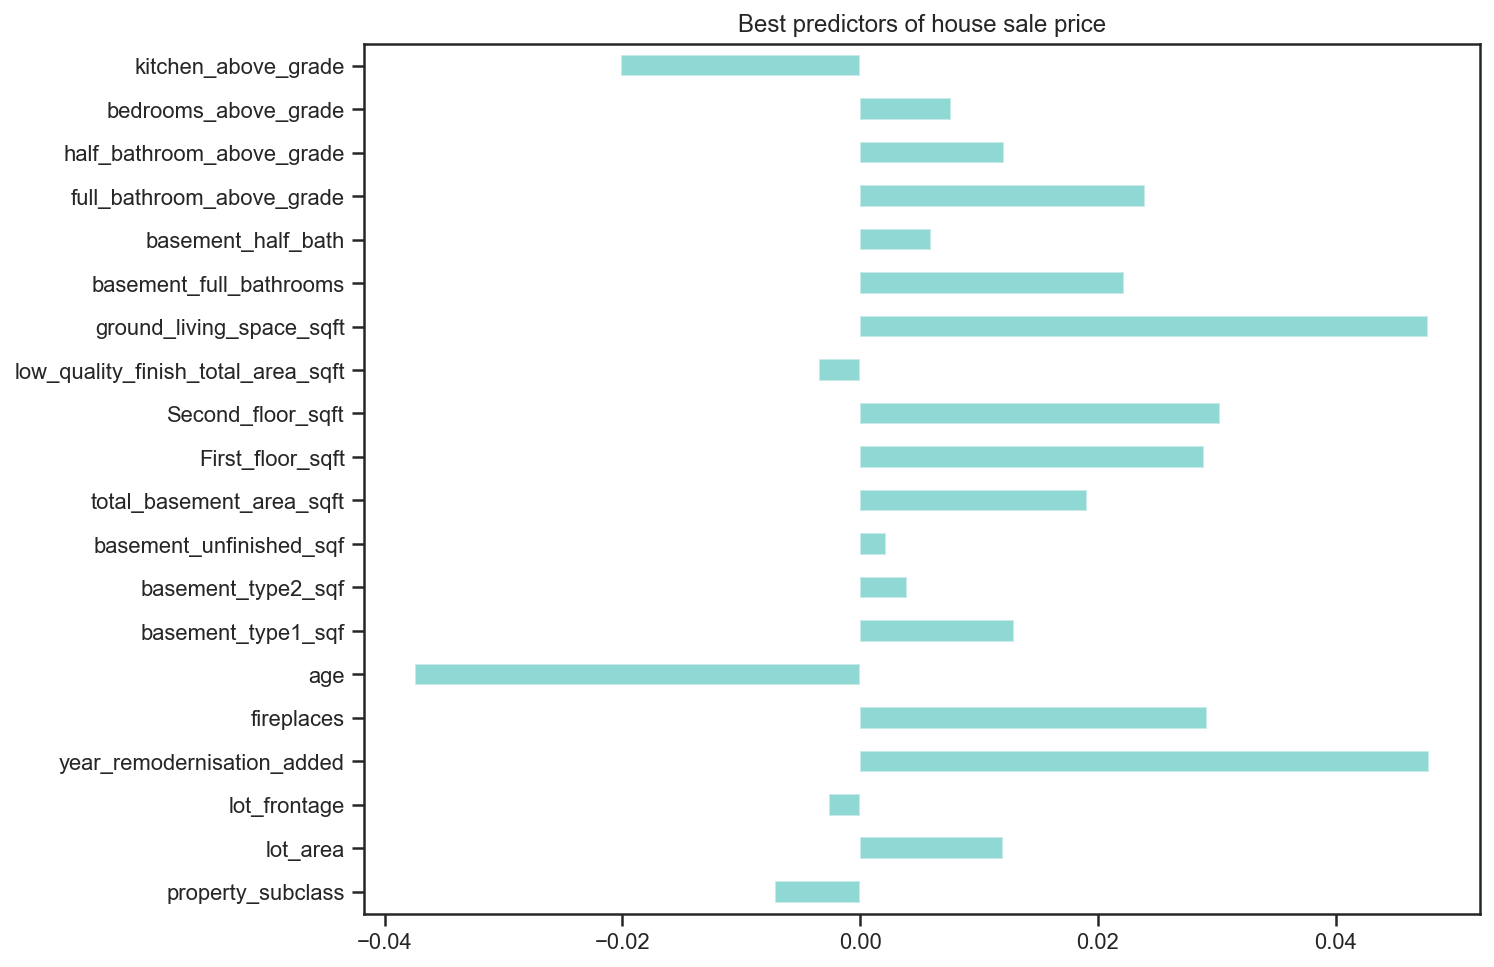

In [59]:
print('Best alpha:', model_r2.alpha_)
print()
alpha = model_r2.alpha_
# create a Ridge model instance
ridge2 = Ridge(alpha=alpha)
model_fitter(ridge2, X_train, y2_train, X_test, y2_test, cv=5)


In [60]:
#Ridge residuals
predicted_test2 = ridge2.predict(X_test)
predicted_train2 = ridge2.predict(X_train)
residual_test2 = y2_test - predicted_test2
residual_train2 = y2_train - predicted_train2


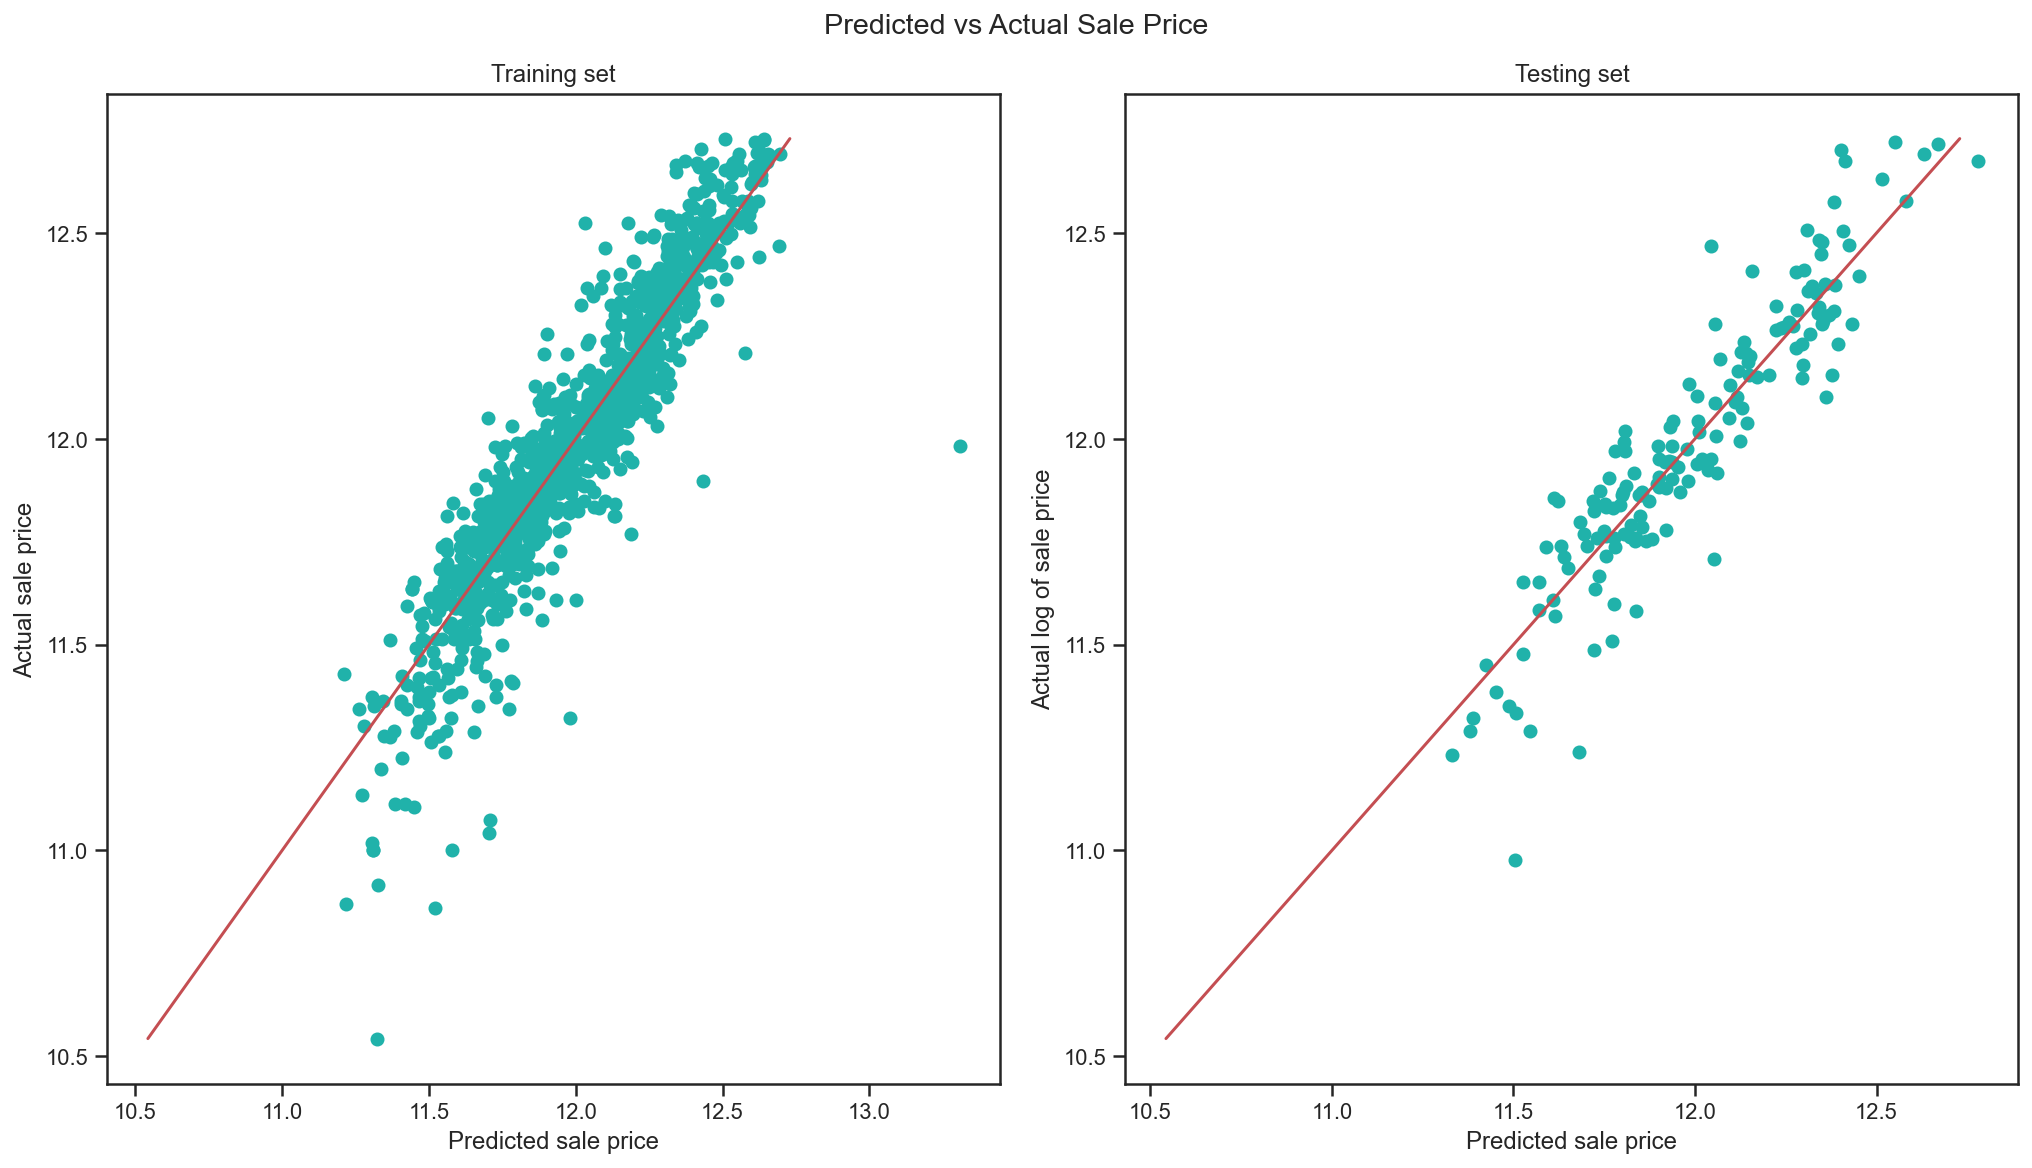

In [61]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8), constrained_layout=True)

fig.suptitle('Predicted vs Actual Sale Price')
ax[0].scatter(predicted_train2,y2_train, color = 'lightseagreen')
ax[0].plot([y2.min(), y2.max()], [y2.min(), y2.max()], c='r')
ax[0].set_ylabel('Actual sale price')
ax[0].set_xlabel('Predicted sale price')
ax[0].set_title('Training set')

ax[1].scatter(predicted_test2,y2_test, color = 'lightseagreen')
ax[1].plot([y2.min(), y2.max()], [y2.min(), y2.max()], c='r')
ax[1].set_ylabel('Actual log of sale price')
ax[1].set_xlabel('Predicted sale price')
ax[1].set_title('Testing set');

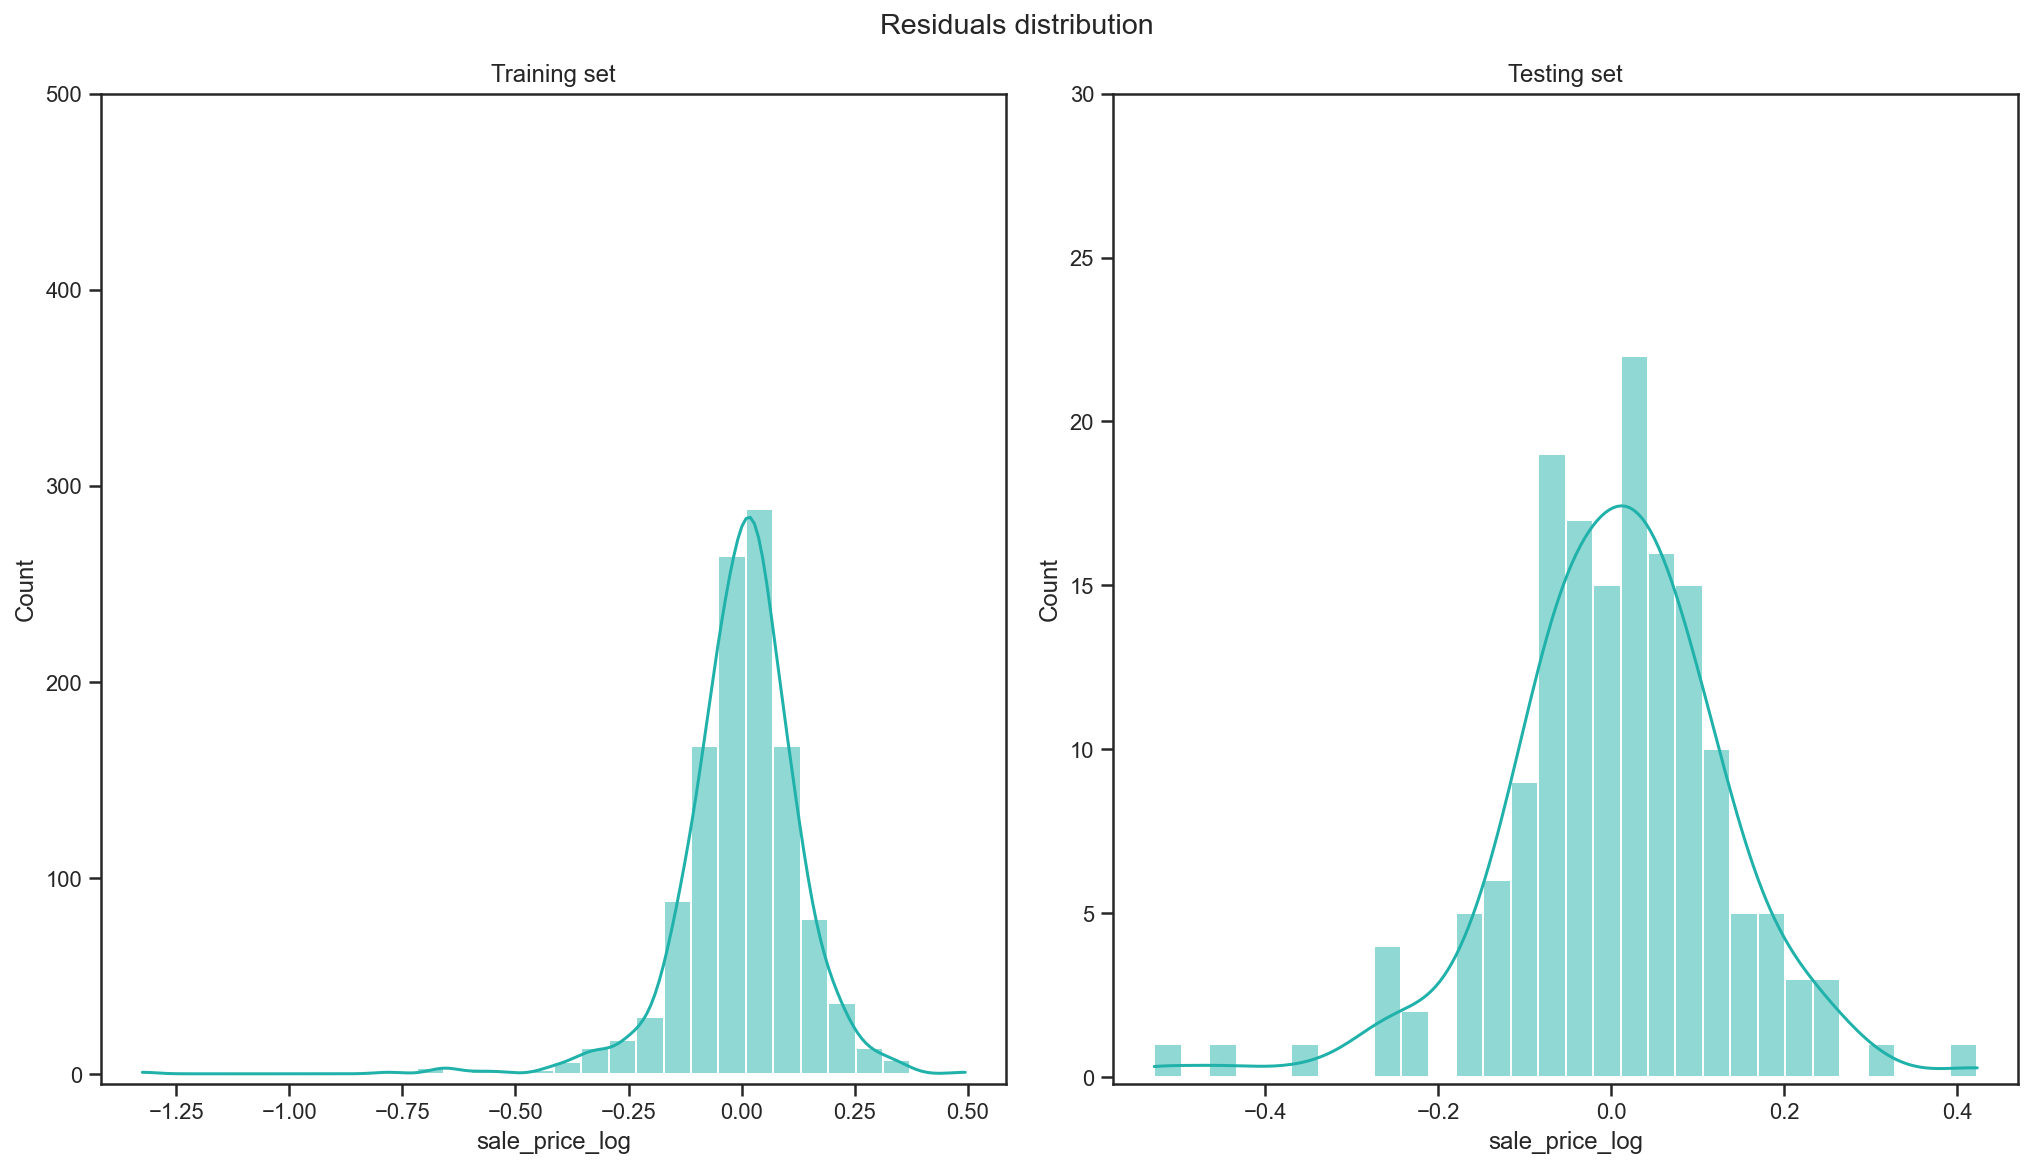

In [62]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8), constrained_layout=True)

fig.suptitle('Residuals distribution')
sns.histplot(data=residual_train2 , bins=30, ax = ax[0], kde = True, alpha=.5, color = 'lightseagreen')
ax[0].set_ylim(-5,500)
ax[0].set_title('Training set')

sns.histplot(data=residual_test2 , bins=30, ax = ax[1], kde = True, alpha=.5, color = 'lightseagreen')
ax[1].set_ylim(-0.2,30)
ax[1].set_title('Testing set');


Using Log of sale price rather than sale price, did not make any improvement when it comes to residual distribution. Left skew on data set and slight left skew on test set can be observed. One distinct property is picked up on the scatterplot as highly overpredicted when it comes to house sale price. 
Based on this, lets remove the property from the data set, quickly re run the Ridge model and look at distribution of residuals (errors between actual price and predicted price) to ensure, they follow normal distribution. 

## REMOVING THE PROPERTY WITH OVER THE TOP PREDICTION AND RE RUNNING RIDGE AND RESIDUAL ANALYSIS 

In [63]:
y_train.loc[1192]

160000

In [64]:
y_train.drop(1192, inplace = True)

In [65]:
X_train.drop(1051, inplace=True)

In [66]:
# creatig a RidgeCV model instance
model_r1 = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
# fit the model
model_r1.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', model_r1.alpha_)

Best alpha: 166.81005372000558


Best alpha: 166.81005372000558

Printing model metrics for: Ridge(alpha=166.81005372000558)


Cross-validated training scores: [0.85988785 0.76461677 0.83514359 0.86642837 0.82495677]
Mean cross-validated training score: 0.8302066686942565
R2 Training Score: 0.8824517142647704
R2 Test Score: 0.8571669847286191
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.1
Mean Absolute Error (Σ|y-pred|/n): 16,267
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 21,922
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 19,855


Printing top coefficients:

                                    coefficients      coef_abs
property_subclass                   -1812.797525   1812.797525
lot_area                             3800.541088   3800.541088
lot_frontage                         1249.670552   1249.670552
year_remodernisation_added           7215.450753   7215.450753
fireplaces                           4246.376265   4246.376265
age                                 -6296.194216   6296

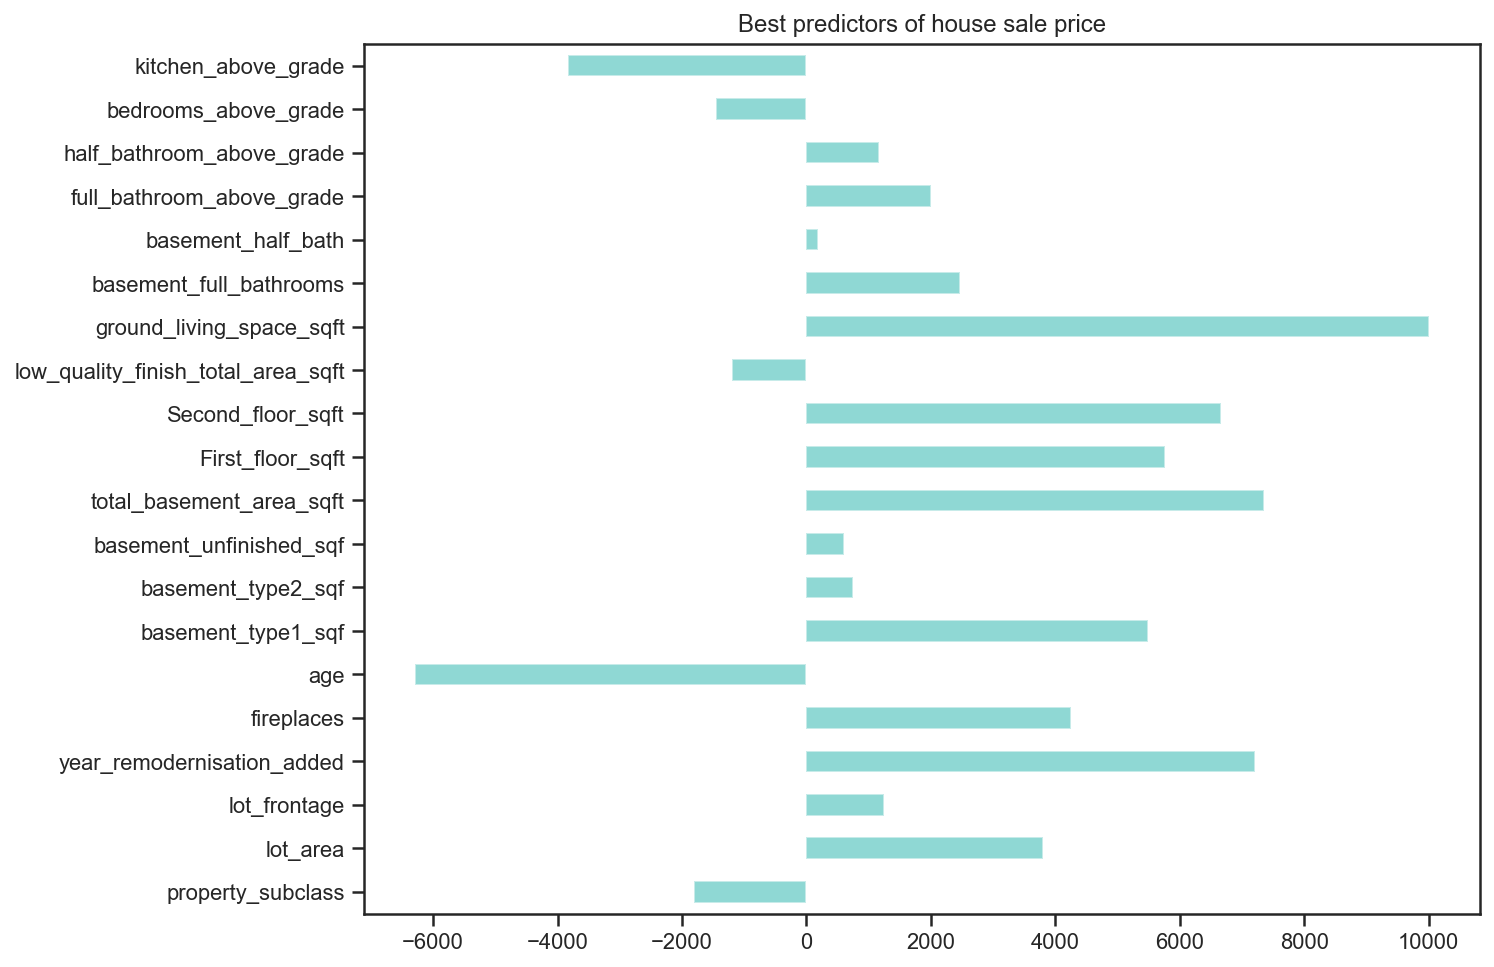

In [67]:
print('Best alpha:', model_r1.alpha_)
print()
alpha = model_r1.alpha_
# create a Ridge model instance
ridge1 = Ridge(alpha=alpha)
model_fitter(ridge1, X_train, y_train, X_test, y_test, cv=5)


In [68]:
# saving the model to pickle for deployment
import pickle 
pickle_out = open("ames_ridge.pkl", mode = "wb") 
pickle.dump(ridge1, pickle_out) 
pickle_out.close()

In [69]:
#Ridge predictions and residuals for train and test sets
predicted_test = ridge1.predict(X_test)
predicted_train = ridge1.predict(X_train)
residual_test2 = y_test - predicted_test
residual_train2 = y_train - predicted_train


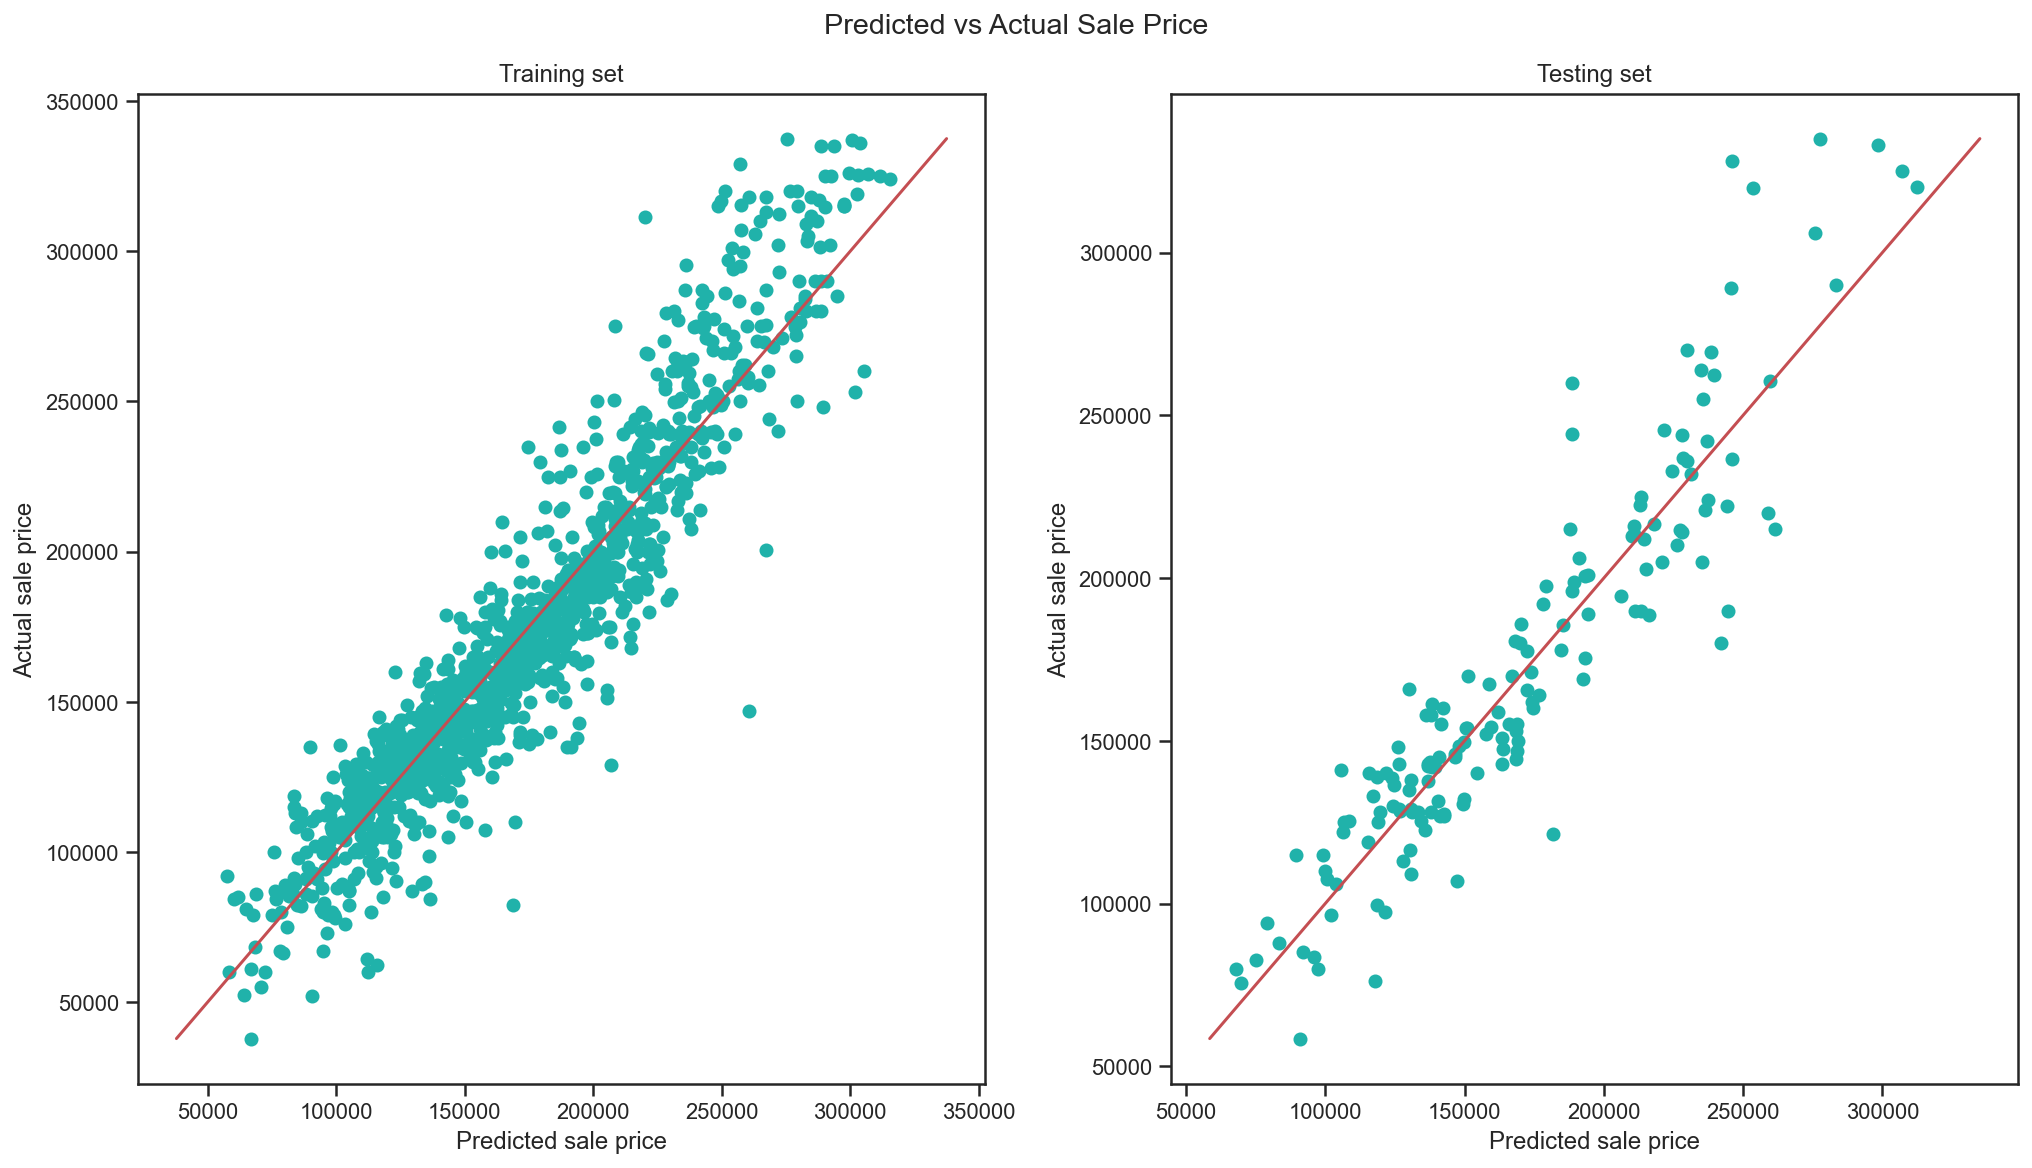

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8), constrained_layout=True)

fig.suptitle('Predicted vs Actual Sale Price')
ax[0].scatter(predicted_train,y_train,  color = 'lightseagreen')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r')
ax[0].set_ylabel('Actual sale price')
ax[0].set_xlabel('Predicted sale price')
ax[0].set_title('Training set')

ax[1].scatter(predicted_test,y_test, color = 'lightseagreen')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
ax[1].set_ylabel('Actual sale price')
ax[1].set_xlabel('Predicted sale price')
ax[1].set_title('Testing set');

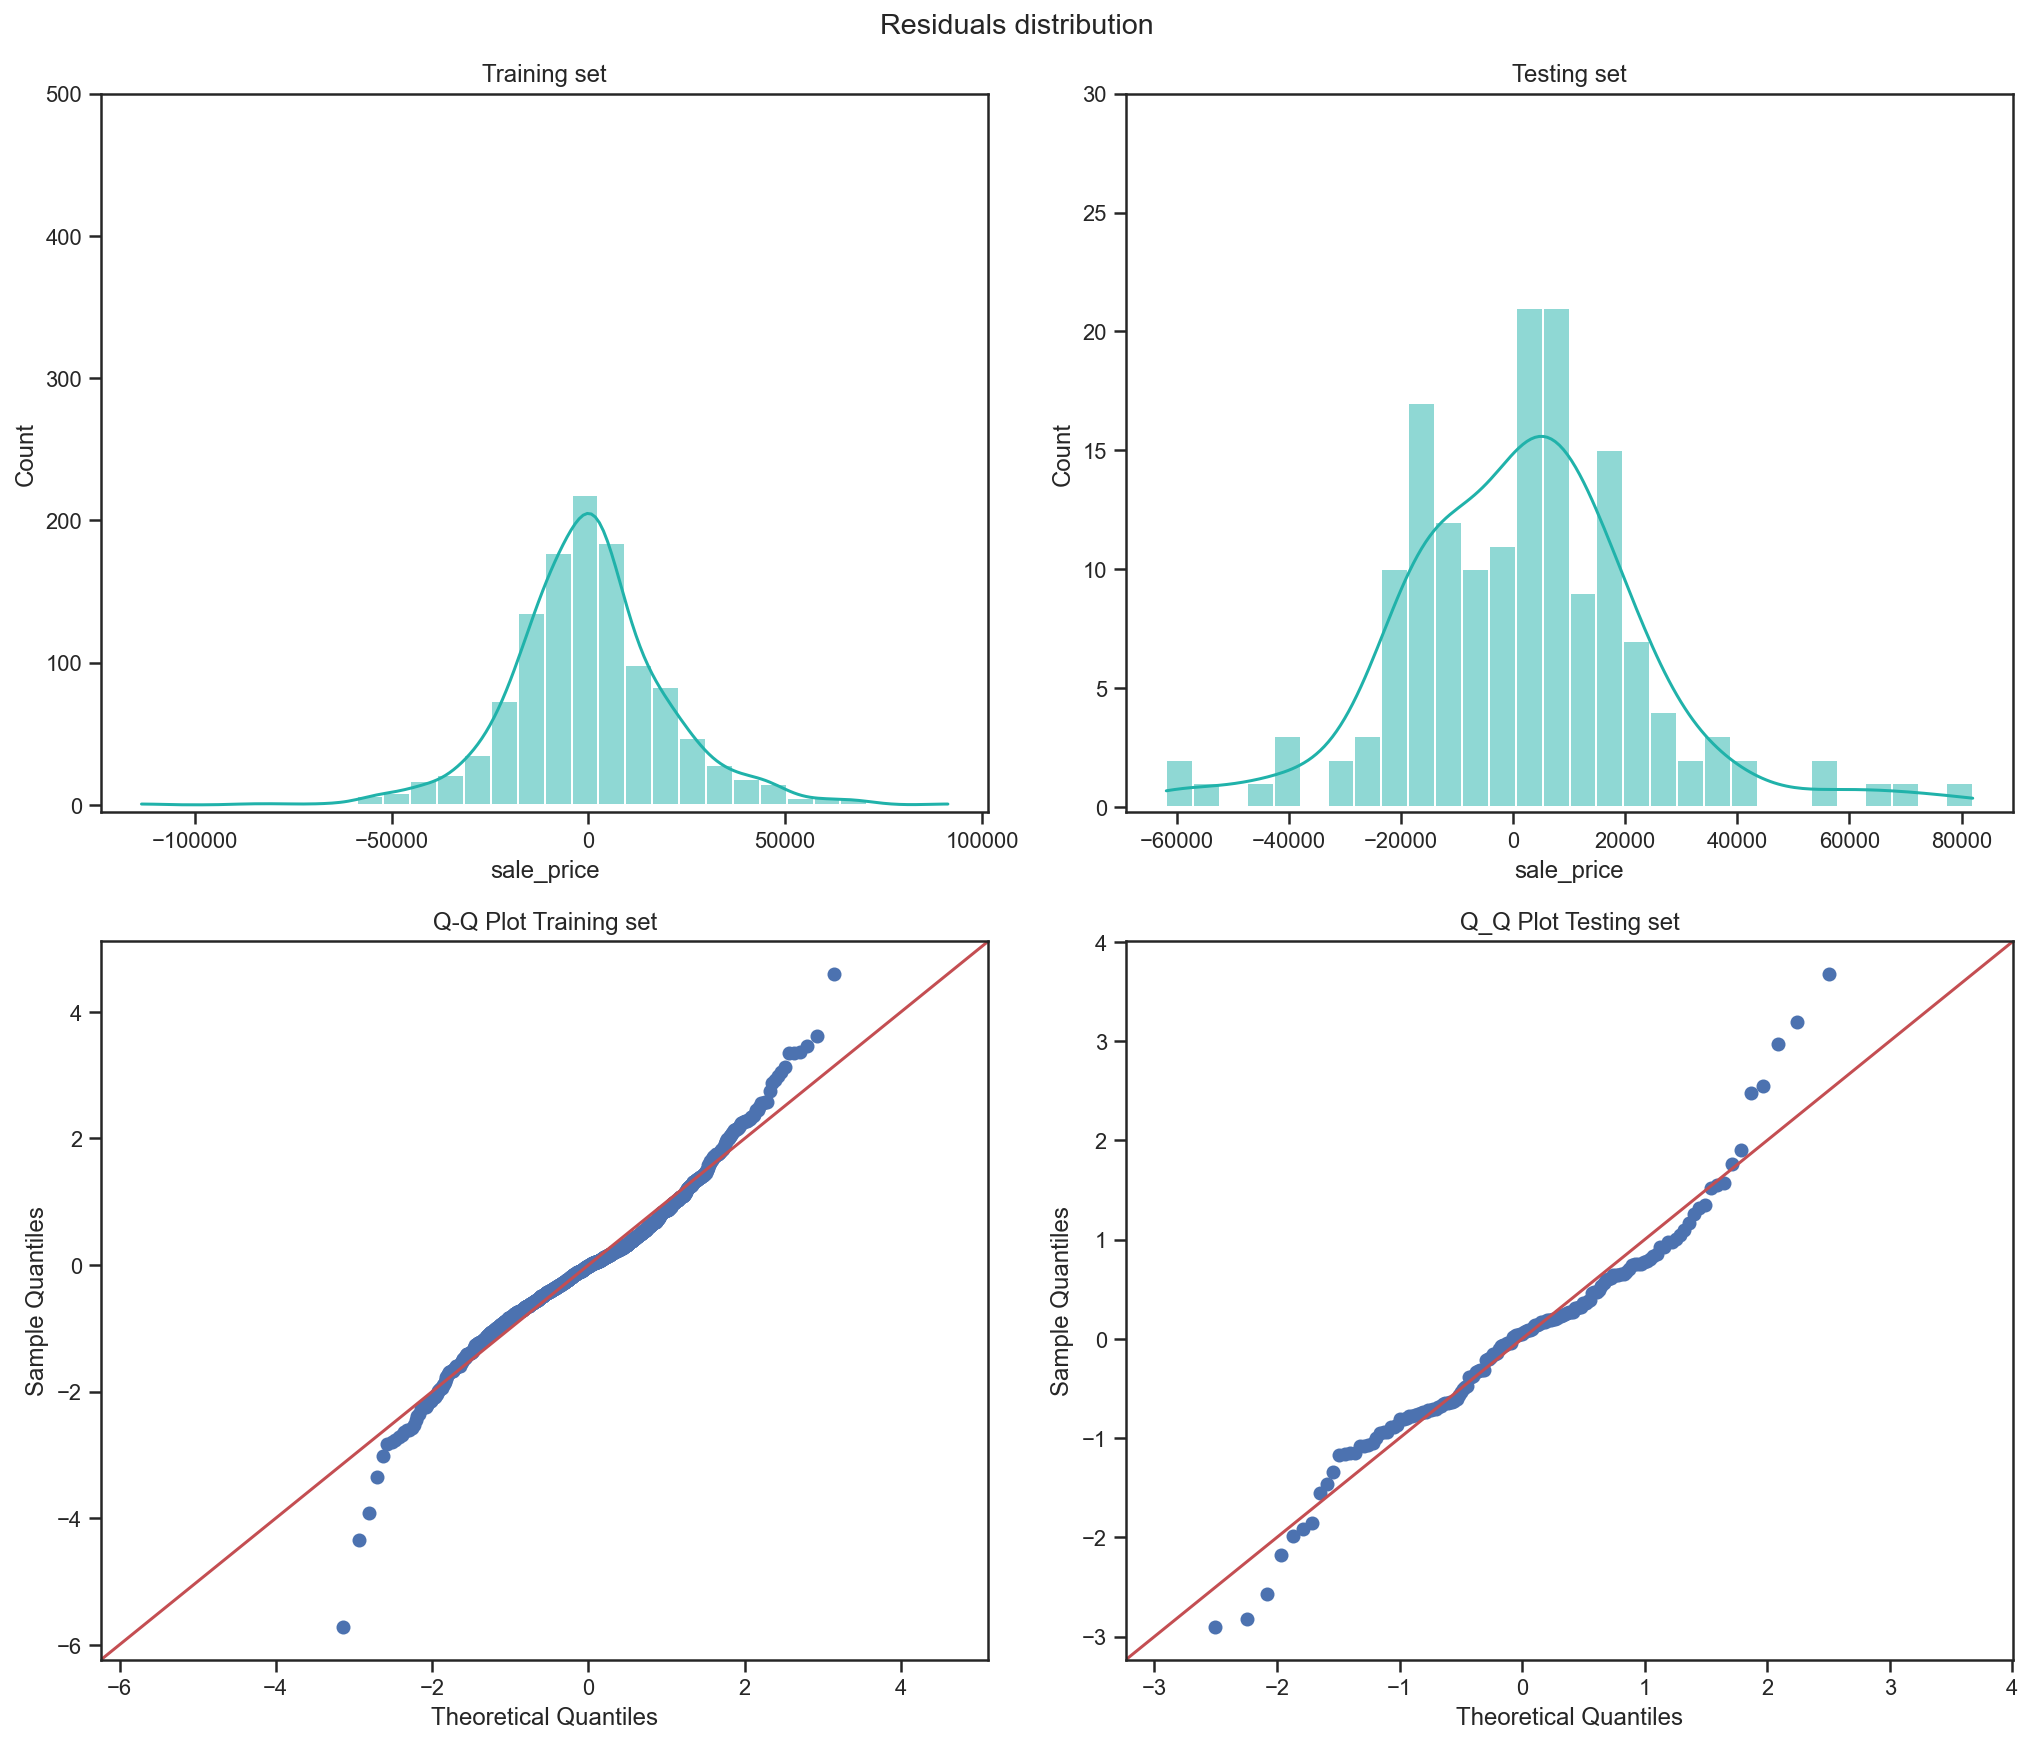

In [71]:
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(ncols=2,nrows =2, figsize=(14, 12), constrained_layout=True)

fig.suptitle('Residuals distribution')
sns.histplot(data=residual_train2 , bins=30, ax = ax[0,0], kde = True, alpha=.5, color = 'lightseagreen')
ax[0,0].set_ylim(-5,500)
ax[0,0].set_title('Training set')

sns.histplot(data=residual_test2 , bins=30, ax = ax[0,1], kde = True, alpha=.5, color = 'lightseagreen')
ax[0,1].set_ylim(-0.2,30)
ax[0,1].set_title('Testing set')


qqplot(np.array(residual_train2), line='45', fit=True, ax = ax[1,0])
ax[1,0].set_title('Q-Q Plot Training set')

qqplot(np.array(residual_test2), line='45', fit=True, ax = ax[1,1])
ax[1,1].set_title('Q_Q Plot Testing set');


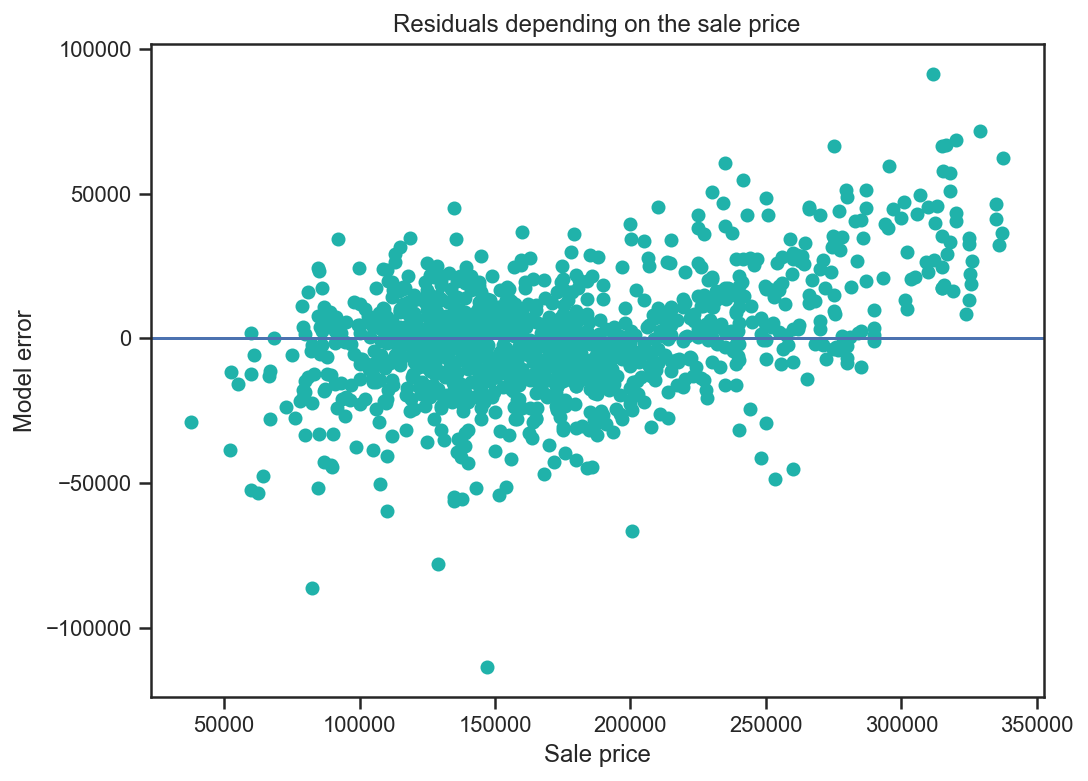

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(y_train, residual_train2, color = 'lightseagreen')
plt.axhline(0)
plt.title("Residuals depending on the sale price")
plt.xlabel("Sale price")
plt.ylabel("Model error")
plt.show()

Removing the data point with over the top prediction, has helped with reducing the error, normalising the distibution of the residuals. Since the distribution of the residual follows the normal trend, it can be assumed our Rigde model performs well, and its residuals will be used for the second part of the modeling. 

## Summary 

Looking at the model scores (Mean cross-validated training score- 0.8302066686942565, R2 Training Score- 0.8824517142647704, R2 Test Score - 0.8571669847286191) along with residual distribution it can be safely said the Ridge model here performs well in predicting sale prices of the properties. 
In terms of best estimators of the house sale price, the model shown the following values to be the most influential:

ground_living_space_sqft - with every sqft increase, sale price increase by 10011.11 USD 
total_basement_area_sqft - with every sqft increase, sale price increase by 7348.24 USD	
year_remodernisation_added - with every remordenisation added, sale price increase by 7215.50 USD
age - with every unit increase in age of the house, the sale price decreasy by 6296.19 USD
basement_type1_sqf - with every sqft increase, the sale price increase by 5485.58 USD
lot_area - every unit increase, the sale price increase by 3800.54 USD


The coeficients shows the values the house sale price could be increased or decreased by. 



Ridge result shows on average, the predictions have an error of 16,267 USD - mean absolute error, or in other words predictions are wrong  by 10 percent  - this is information is obtained from mean absolute percentage error. 
Looking at the RMSE, which is square root of the average squared difference between the predicted values and the actual values in a dataset. In case of Rigde, 21,922 were obtained in terms of USD for the testing set.





<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [73]:
# A:

In [74]:
house_renovate.head()

overall_quality  overall_condition roof_style roof_matl  \
0                7                  5      Gable   CompShg   
1                6                  8      Gable   CompShg   
2                7                  5      Gable   CompShg   
3                7                  5      Gable   CompShg   
4                8                  5      Gable   CompShg   

  exterior_material_1 exterior_material_2 external_material_quality  \
0             VinylSd             VinylSd                        Gd   
1             MetalSd             MetalSd                        TA   
2             VinylSd             VinylSd                        Gd   
3             Wd Sdng             Wd Shng                        TA   
4             VinylSd             VinylSd                        Gd   

  external_material_condition heating heating_quality air_conditioning  \
0                          TA    GasA              Ex                Y   
1                          TA    GasA              Ex                Y   
2                          TA    GasA              Ex                Y   
3                          TA    GasA              Gd                Y   
4                          TA    GasA              Ex                Y   

  electrical kitchen_quality home_funcionality utilities  fireplaces  \
0      SBrkr              Gd               Typ    AllPub           0   
1      SBrkr              TA               Typ    AllPub           1   
2      SBrkr              Gd               Typ    AllPub           1   
3      SBrkr              Gd               Typ    AllPub           1   
4      SBrkr              Gd               Typ    AllPub           1   

  garage_interior_finish garage_quality garage_condition fence  \
0                    RFn             TA               TA   NaN   
1                    RFn             TA               TA   NaN   
2                    RFn             TA               TA   NaN   
3                    Unf             TA               TA   NaN   
4                    RFn             TA               TA   NaN   

  masonry_veneer_type  
0             BrkFace  
1                None  
2             BrkFace  
3                None  
4             BrkFace

In [75]:
house_renovate.dtypes

overall_quality                 int64
overall_condition               int64
roof_style                     object
roof_matl                      object
exterior_material_1            object
exterior_material_2            object
external_material_quality      object
external_material_condition    object
heating                        object
heating_quality                object
air_conditioning               object
electrical                     object
kitchen_quality                object
home_funcionality              object
utilities                      object
fireplaces                      int64
garage_interior_finish         object
garage_quality                 object
garage_condition               object
fence                          object
masonry_veneer_type            object
dtype: object

In [76]:
house_renovate.columns

Index(['overall_quality', 'overall_condition', 'roof_style', 'roof_matl',
       'exterior_material_1', 'exterior_material_2',
       'external_material_quality', 'external_material_condition', 'heating',
       'heating_quality', 'air_conditioning', 'electrical', 'kitchen_quality',
       'home_funcionality', 'utilities', 'fireplaces',
       'garage_interior_finish', 'garage_quality', 'garage_condition', 'fence',
       'masonry_veneer_type'],
      dtype='object')

In [77]:
house_renovate = pd.get_dummies(house_renovate,drop_first = True)
house_renovate.head()

overall_quality  overall_condition  fireplaces  roof_style_Gable  \
0                7                  5           0                 1   
1                6                  8           1                 1   
2                7                  5           1                 1   
3                7                  5           1                 1   
4                8                  5           1                 1   

   roof_style_Gambrel  roof_style_Hip  roof_style_Mansard  roof_style_Shed  \
0                   0               0                   0                0   
1                   0               0                   0                0   
2                   0               0                   0                0   
3                   0               0                   0                0   
4                   0               0                   0                0   

   roof_matl_CompShg  roof_matl_Membran  roof_matl_Metal  roof_matl_Roll  \
0                  1                  0                0               0   
1                  1                  0                0               0   
2                  1                  0                0               0   
3                  1                  0                0               0   
4                  1                  0                0               0   

   roof_matl_Tar&Grv  roof_matl_WdShake  roof_matl_WdShngl  \
0                  0                  0                  0   
1                  0                  0                  0   
2                  0                  0                  0   
3                  0                  0                  0   
4                  0                  0                  0   

   exterior_material_1_BrkComm  exterior_material_1_BrkFace  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   exterior_material_1_CBlock  exterior_material_1_CemntBd  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   exterior_material_1_HdBoard  exterior_material_1_ImStucc  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   exterior_material_1_MetalSd  exterior_material_1_Plywood  \
0                            0                            0   
1                            1                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   exterior_material_1_Stone  exterior_material_1_Stucco  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          0                           0   

   exterior_material_1_VinylSd  exterior_material_1_Wd Sdng  \
0                            1                            0   
1                            0                            0   
2                            1                            0   
3                            0                            1   
4                            1                            0   

   exterior_material_1_WdSh

In [78]:
house_renovate.corr()

overall_quality  overall_condition  \
overall_quality                        1.000000          -0.120562   
overall_condition                     -0.120562           1.000000   
fireplaces                             0.335525          -0.035819   
roof_style_Gable                      -0.102719          -0.038875   
roof_style_Gambrel                    -0.030602           0.099984   
roof_style_Hip                         0.114360           0.002284   
roof_style_Mansard                    -0.002292           0.034233   
roof_style_Shed                       -0.001223          -0.004080   
roof_matl_CompShg                     -0.061951          -0.018042   
roof_matl_Membran                      0.021087           0.033969   
roof_matl_Metal                       -0.000864          -0.015168   
roof_matl_Roll                        -0.022815          -0.015168   
roof_matl_Tar&Grv                     -0.002742           0.022031   
roof_matl_WdShake                      0.066884           0.032054   
roof_matl_WdShngl                      0.036550          -0.026291   
exterior_material_1_BrkComm           -0.022815          -0.064305   
exterior_material_1_BrkFace            0.008303           0.033839   
exterior_material_1_CBlock            -0.044766           0.009400   
exterior_material_1_CemntBd            0.062625           0.012318   
exterior_material_1_HdBoard           -0.090444           0.043123   
exterior_material_1_ImStucc            0.043037          -0.015168   
exterior_material_1_MetalSd           -0.167701           0.089443   
exterior_material_1_Plywood           -0.036271          -0.013609   
exterior_material_1_Stone              0.029832           0.030678   
exterior_material_1_Stucco             0.005662           0.043401   
exterior_material_1_VinylSd            0.349849          -0.210752   
exterior_material_1_Wd Sdng           -0.162028           0.121916   
exterior_material_1_WdShing           -0.055972           0.028601   
exterior_material_2_AsphShn           -0.016750           0.030678   
exterior_material_2_Brk Cmn           -0.011099          -0.027175   
exterior_material_2_BrkFace            0.020824          -0.001924   
exterior_material_2_CBlock            -0.044766           0.009400   
exterior_material_2_CmentBd            0.066510           0.011081   
exterior_material_2_HdBoard           -0.066980           0.050533   
exterior_material_2_ImStucc            0.020892          -0.034305   
exterior_material_2_MetalSd           -0.159274           0.084341   
exterior_material_2_Other              0.043037          -0.015168   
exterior_material_2_Plywood           -0.090444          -0.001631   
exterior_material_2_Stone             -0.001498          -0.012096   
exterior_material_2_Stucco            -0.022349           0.005983   
exterior_material_2_VinylSd            0.349623          -0.204528   
exterior_material_2_Wd Sdng           -0.160008           0.145806   
exterior_material_2_Wd Shng           -0.008893           0.033011   
external_material_quality_Fa          -0.127361          -0.078496   
external_material_quality_Gd           0.597627          -0.197871   
external_material_quality_TA          -0.638628           0.197974   
external_material_condition_Fa        -0.122009          -0.113942   
external_material_condition_Gd        -0.087209           0.338932   
external_material_condition_Po        -0.066717          -0.088873   
external_material_condition_TA         0.126483          -0.284027   
heating_GasW                          -0.031852          -0.001663   
heating_Grav                          -0.102075          -0.058834   
heating_OthW                           0.029832          -0.021459   
heating_quality_Fa                    -0.111190          -0.051569   
heating_quality_Gd                    -0.117815           0.125809   
heating_quality_Po                    -0.022815           0.009400   
heating_quality_TA                    -0.3

## MODELLING

## Defining target and predictors

In [79]:
# in this model I have used residuals from model 1 
X_1 = house_renovate

In [80]:
house_renovate.shape

(1346, 88)

In [81]:
X_1.head()

overall_quality  overall_condition  fireplaces  roof_style_Gable  \
0                7                  5           0                 1   
1                6                  8           1                 1   
2                7                  5           1                 1   
3                7                  5           1                 1   
4                8                  5           1                 1   

   roof_style_Gambrel  roof_style_Hip  roof_style_Mansard  roof_style_Shed  \
0                   0               0                   0                0   
1                   0               0                   0                0   
2                   0               0                   0                0   
3                   0               0                   0                0   
4                   0               0                   0                0   

   roof_matl_CompShg  roof_matl_Membran  roof_matl_Metal  roof_matl_Roll  \
0                  1                  0                0               0   
1                  1                  0                0               0   
2                  1                  0                0               0   
3                  1                  0                0               0   
4                  1                  0                0               0   

   roof_matl_Tar&Grv  roof_matl_WdShake  roof_matl_WdShngl  \
0                  0                  0                  0   
1                  0                  0                  0   
2                  0                  0                  0   
3                  0                  0                  0   
4                  0                  0                  0   

   exterior_material_1_BrkComm  exterior_material_1_BrkFace  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   exterior_material_1_CBlock  exterior_material_1_CemntBd  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   exterior_material_1_HdBoard  exterior_material_1_ImStucc  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   exterior_material_1_MetalSd  exterior_material_1_Plywood  \
0                            0                            0   
1                            1                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   exterior_material_1_Stone  exterior_material_1_Stucco  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          0                           0   

   exterior_material_1_VinylSd  exterior_material_1_Wd Sdng  \
0                            1                            0   
1                            0                            0   
2                            1                            0   
3                            0                            1   
4                            1                            0   

   exterior_material_1_WdSh

In [82]:
X1_train = X_1[house['year_sold'].isin([2008, 2007, 2006, 2009])]
X1_test = X_1[house['year_sold'] == 2010]

y_train = residual_train2
y_test = residual_test2

In [83]:
print(X1_train.shape)
print(y_train.shape)

(1185, 88)
(1184,)


In [84]:
X1_train.drop(1051, inplace=True)

In [85]:
# training and test set baseline
print(y_train.value_counts(normalize=True).max())
print(y_test.value_counts(normalize=True).max())

0.0008445945945945946
0.006211180124223602


In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

X1_train = pd.DataFrame(X1_train, columns=X_1.columns)
X1_test = pd.DataFrame(X1_test, columns=X_1.columns)

Printing model metrics for: LinearRegression()


Cross-validated training scores: [-2.24868481e+26 -2.14753392e+25 -3.21353198e+26 -3.58919236e+25
 -4.06159281e+23]
Mean cross-validated training score: -1.2079902018035979e+26
R2 Training Score: 0.28605938777232653
R2 Test Score: -1.521737979575521e+23
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 14.97
Mean Absolute Error (Σ|y-pred|/n): 672,166,086,223,049
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 8,528,831,504,908,238
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 16,776


Printing top coefficients:

                             coefficients      coef_abs
overall_quality              4.644567e+03  4.644567e+03
overall_condition            4.673279e+03  4.673279e+03
fireplaces                  -1.404465e+03  1.404465e+03
roof_style_Gable            -6.970090e+03  6.970090e+03
roof_style_Gambrel          -9.981810e+02  9.981810e+02
roof_style_Hip              -5.855391e+03  5.855391e+03
roof_style_Mansard  

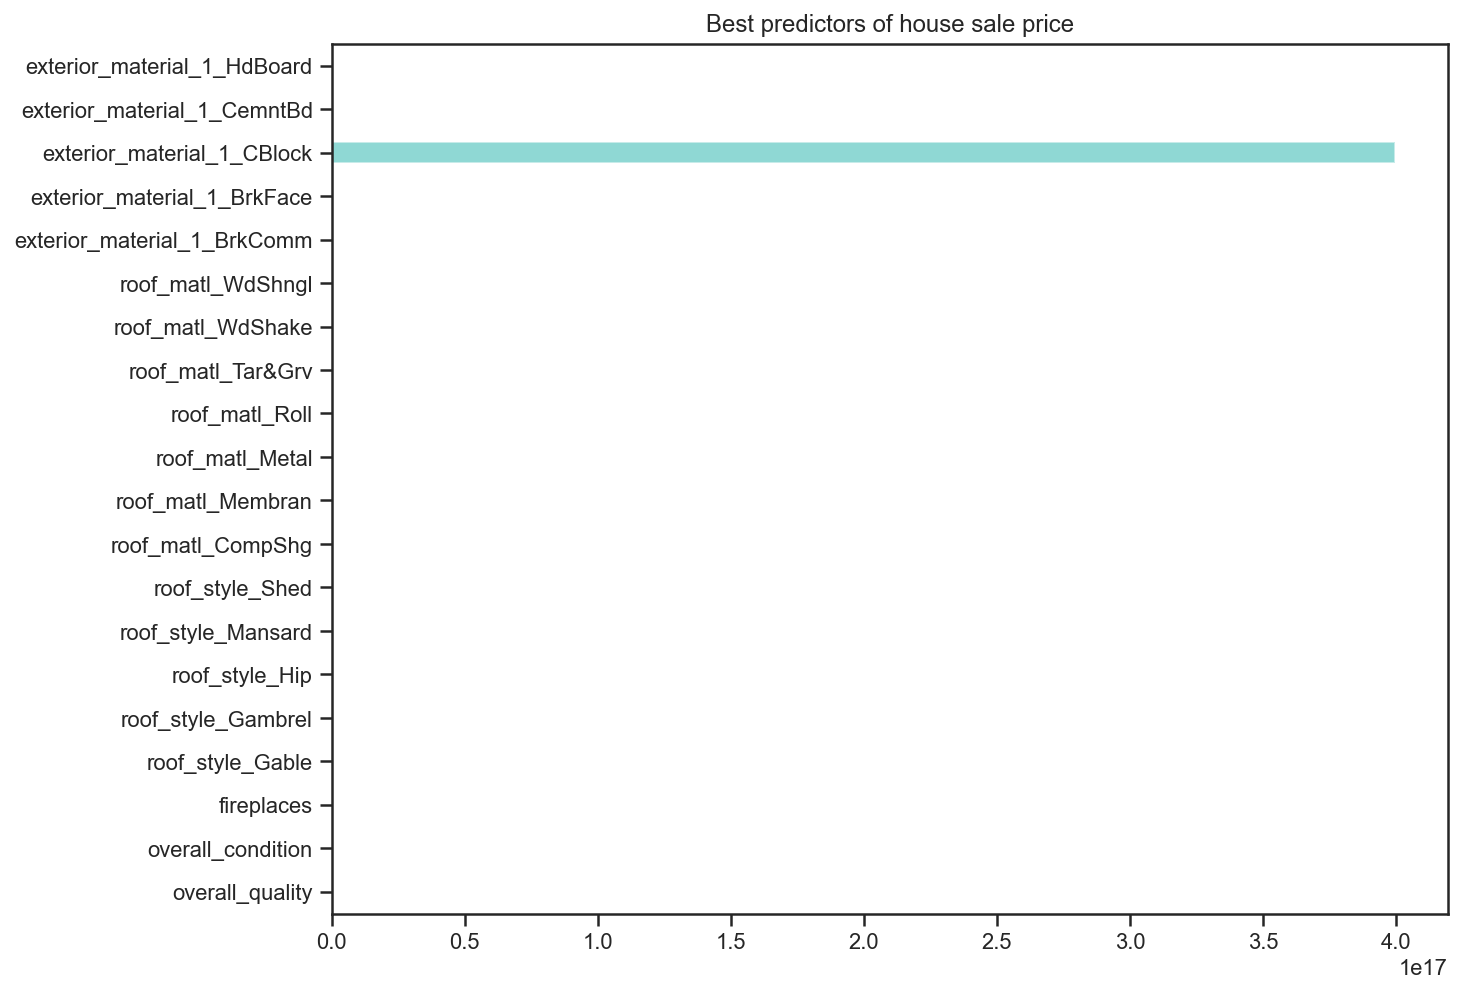

In [87]:
# create a linear regression model instance
linreg2 = LinearRegression()

model_fitter(linreg2, X1_train, y_train, X1_test, y_test, cv=5)

Best alpha: 166.81005372000558

Printing model metrics for: Ridge(alpha=166.81005372000558)


Cross-validated training scores: [0.10537778 0.10743856 0.20574582 0.23443536 0.08554218]
Mean cross-validated training score: 0.14770794134758847
R2 Training Score: 0.27017443031679744
R2 Test Score: 0.13851900152160357
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 8.17
Mean Absolute Error (Σ|y-pred|/n): 15,224
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 20,293
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 16,962


Printing top coefficients:

                             coefficients     coef_abs
overall_quality               4053.919329  4053.919329
overall_condition             3985.907965  3985.907965
fireplaces                   -1065.818226  1065.818226
roof_style_Gable              -907.531746   907.531746
roof_style_Gambrel             213.621667   213.621667
roof_style_Hip                 111.477777   111.477777
roof_style_Mansard             594.757760   

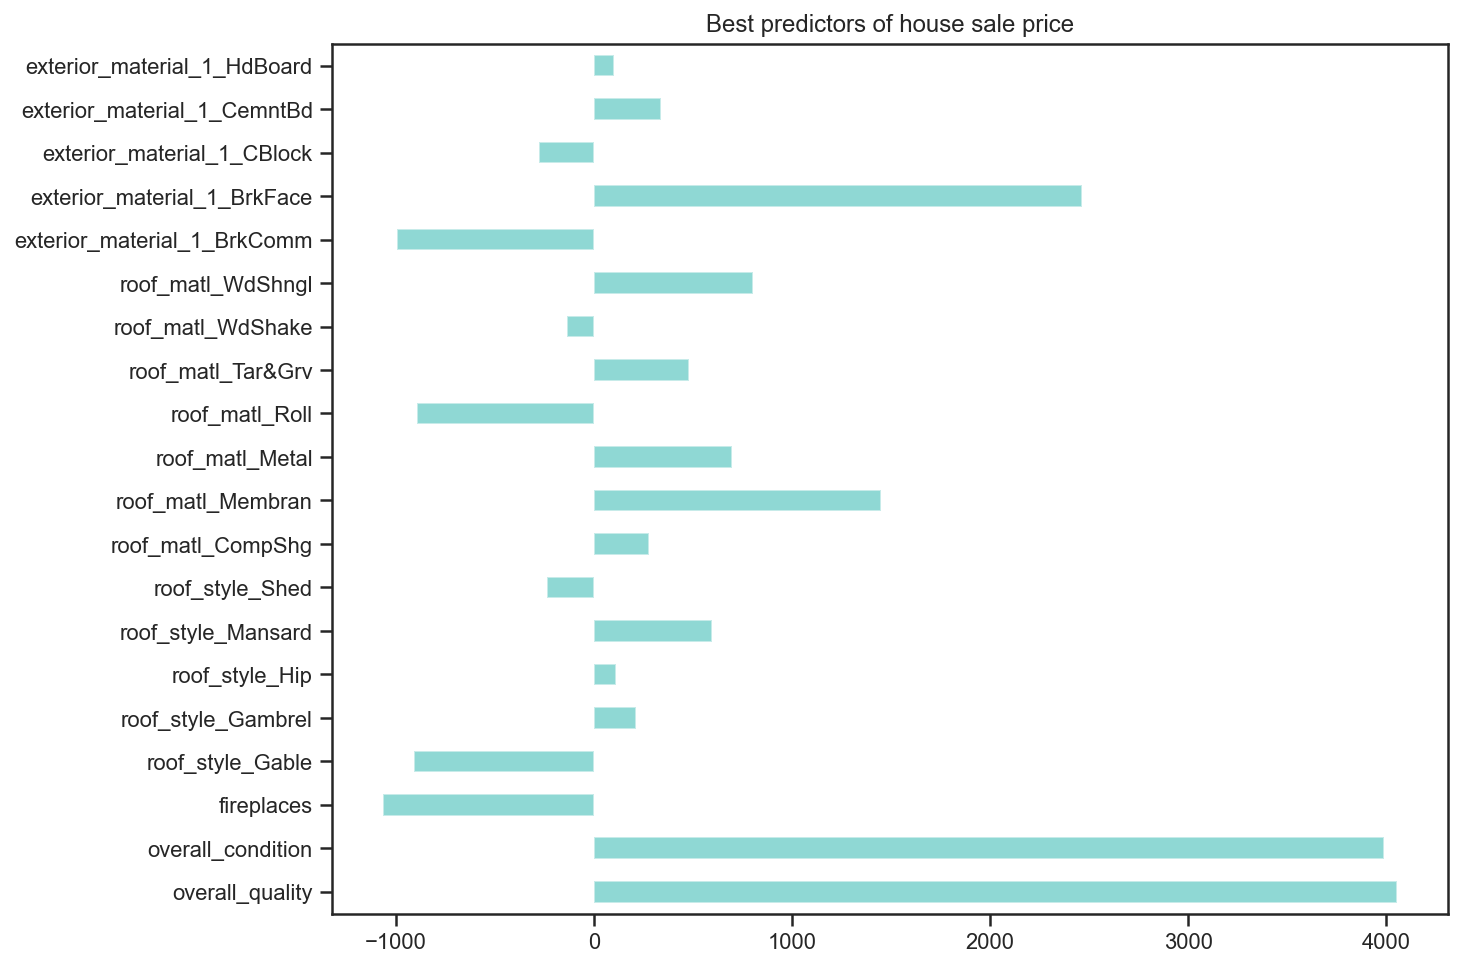

In [88]:
# creatig a RidgeCV model instance
model_r2 = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
# fit the model
model_r2.fit(X1_train, y_train)
# get the best alpha

print('Best alpha:', model_r2.alpha_)
print()
alpha = model_r2.alpha_
# create a Ridge model instance
ridge2 = Ridge(alpha=alpha)
model_fitter(ridge2, X1_train, y_train, X1_test, y_test, cv=5)


Best alpha: 1291.5496650148827

Printing model metrics for: Lasso(alpha=166.81005372000558)


Cross-validated training scores: [0.11777615 0.11616677 0.22559714 0.244048   0.08223712]
Mean cross-validated training score: 0.15716503681859184
R2 Training Score: 0.27141744790425393
R2 Test Score: 0.17173543401697067
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 8.86
Mean Absolute Error (Σ|y-pred|/n): 15,127
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 19,898
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 16,948


Printing top coefficients:

                             coefficients     coef_abs
overall_quality               4880.502853  4880.502853
overall_condition             4432.189466  4432.189466
fireplaces                   -1286.523145  1286.523145
roof_style_Gable              -825.468391   825.468391
roof_style_Gambrel              12.291252    12.291252
roof_style_Hip                   0.000000     0.000000
roof_style_Mansard             397.508751   

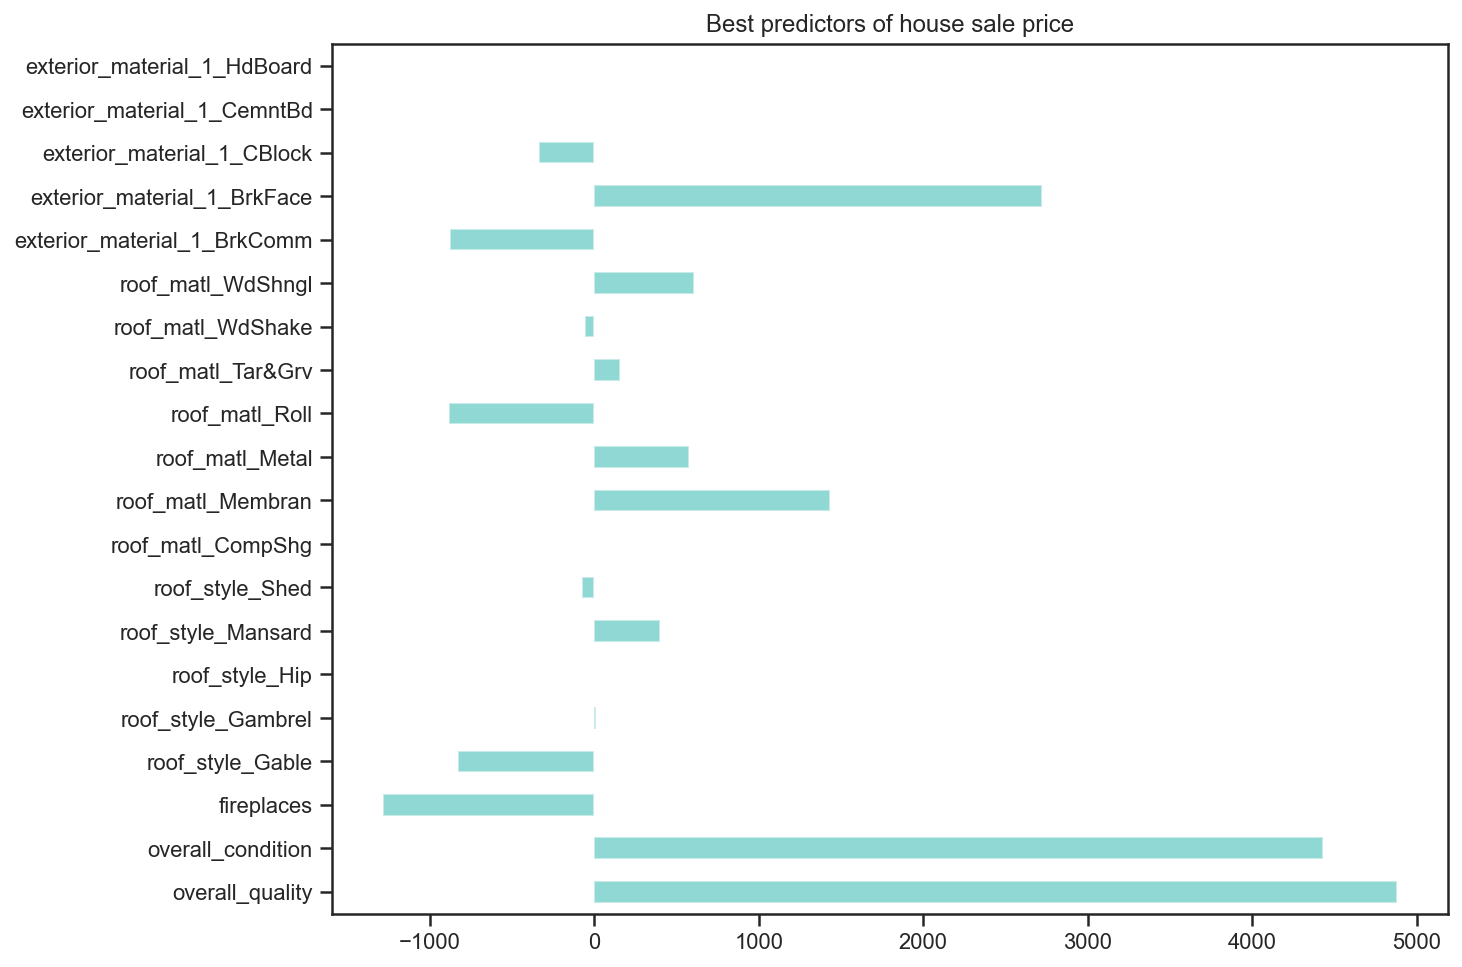

In [89]:
# create a LassoCV model instance
model_l2 = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
# fit the model
model_l2.fit(X1_train, y_train)
print('Best alpha:', model_l.alpha_)
print()
alpha = model_l2.alpha_
# create a Ridge model instance
lasso2 = Lasso(alpha=alpha)
model_fitter(lasso2, X1_train, y_train, X1_test, y_test, cv=5)


Best alpha: 166.81005372000558

Best l1-ratio: 1.0

Printing model metrics for: ElasticNet(alpha=166.81005372000558, l1_ratio=1.0)


Cross-validated training scores: [0.11777615 0.11616677 0.22559714 0.244048   0.08223712]
Mean cross-validated training score: 0.15716503681859184
R2 Training Score: 0.27141744790425393
R2 Test Score: 0.17173543401697067
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 8.86
Mean Absolute Error (Σ|y-pred|/n): 15,127
Root Mean Squared Error on test data(sqrt(Σ(y-pred)^2/n)):$ 19,898
Root Mean Squared Error on train data(sqrt(Σ(y-pred)^2/n)):$ 16,948


Printing top coefficients:

                             coefficients     coef_abs
overall_quality               4880.502853  4880.502853
overall_condition             4432.189466  4432.189466
fireplaces                   -1286.523145  1286.523145
roof_style_Gable              -825.468391   825.468391
roof_style_Gambrel              12.291252    12.291252
roof_style_Hip                   0.000000     0.000000
roof_

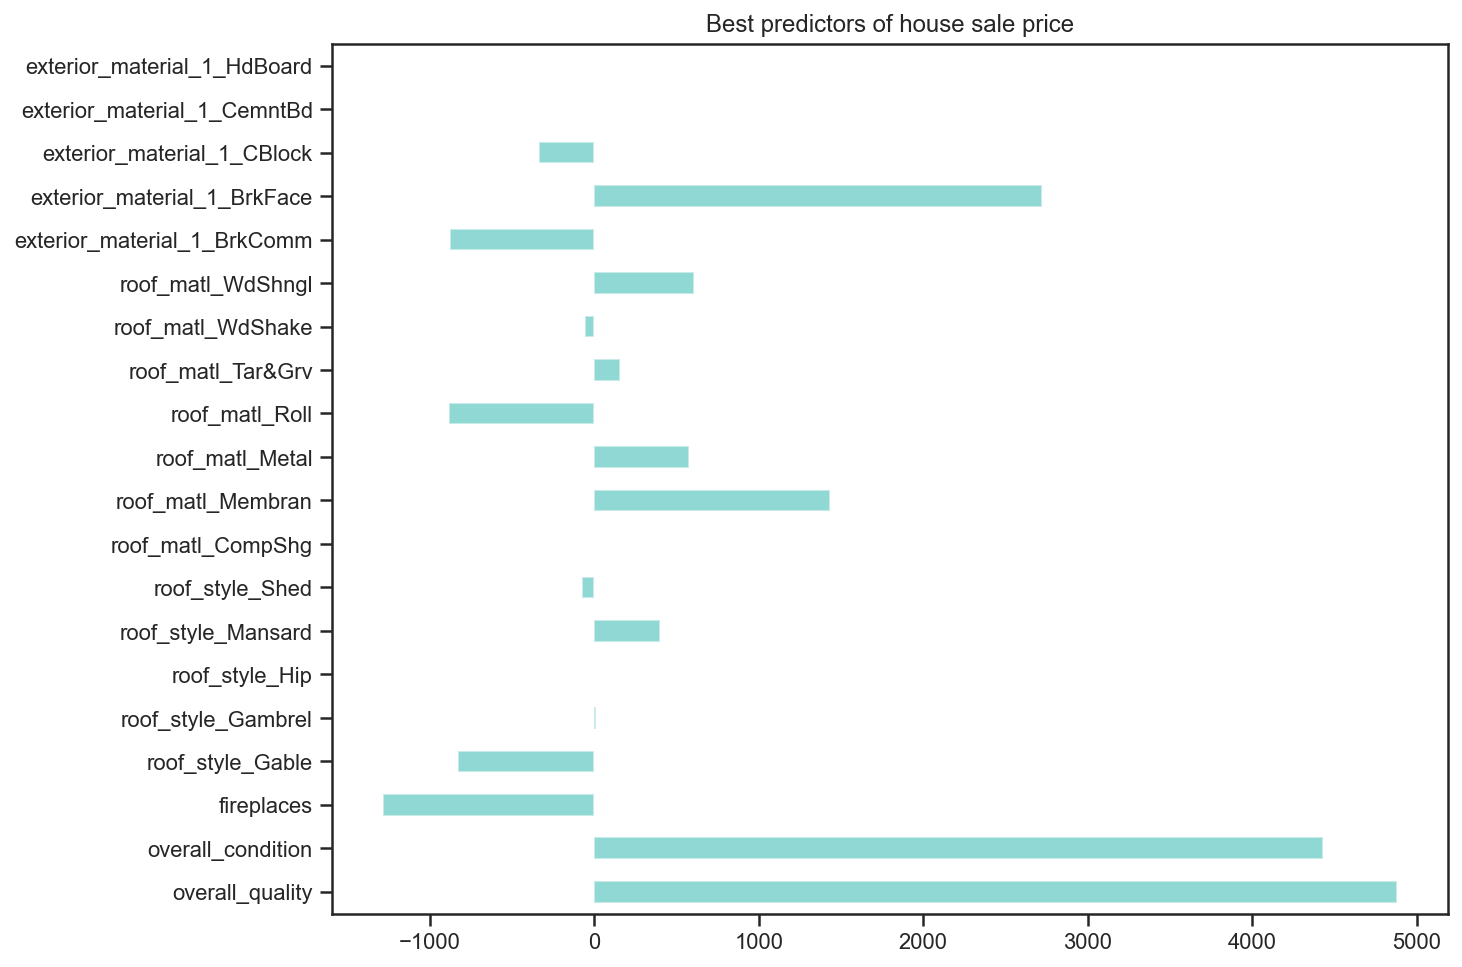

In [90]:
# create an ElastinNetCV model instance
model_e2 = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5, max_iter = 100000)
# fit the model
model_e2.fit(X1_train, y_train)
alpha = model_e2.alpha_ 
l1_ratio = model_e2.l1_ratio_
# get the best alpha
print('Best alpha:', model_e2.alpha_)
print()
# get the best l1-ratio
print('Best l1-ratio:', model_e2.l1_ratio_)
print()
# create an ElasticNet model instance
elasticnet2 = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
model_fitter(elasticnet2, X1_train, y_train, X1_test, y_test, cv=5)


In [91]:
summary2 = {'model': ['Linear','Ridge', 'Lasso', 'ElasticNet'],
          'R2_training_score': [linreg2.score(X1_train, y_train), ridge2.score(X1_train, y_train), lasso2.score(X1_train, y_train), elasticnet2.score(X1_train, y_train)],
          'R2_testing_score': [linreg2.score(X1_test, y_test), ridge2.score(X1_test, y_test), lasso2.score(X1_test, y_test), elasticnet2.score(X1_test, y_test)],
           'CV_mean_score': [-4.1248, 0.1156, 0.1466, 0.1466],
           'RMSE in £' : [51987420113535, 21327, 21392, 21392]}
                            
summary2 = pd.DataFrame.from_dict(summary2)

summary2.round(decimals=4)

model  R2_training_score  R2_testing_score  CV_mean_score  \
0      Linear             0.2861     -1.521738e+23        -4.1248   
1       Ridge             0.2702      1.385000e-01         0.1156   
2       Lasso             0.2714      1.717000e-01         0.1466   
3  ElasticNet             0.2714      1.717000e-01         0.1466   

        RMSE in £  
0  51987420113535  
1           21327  
2           21392  
3           21392

In [92]:
#Ridge residuals
predicted_test2 = ridge2.predict(X1_test)
predicted_train2 = ridge2.predict(X1_train)

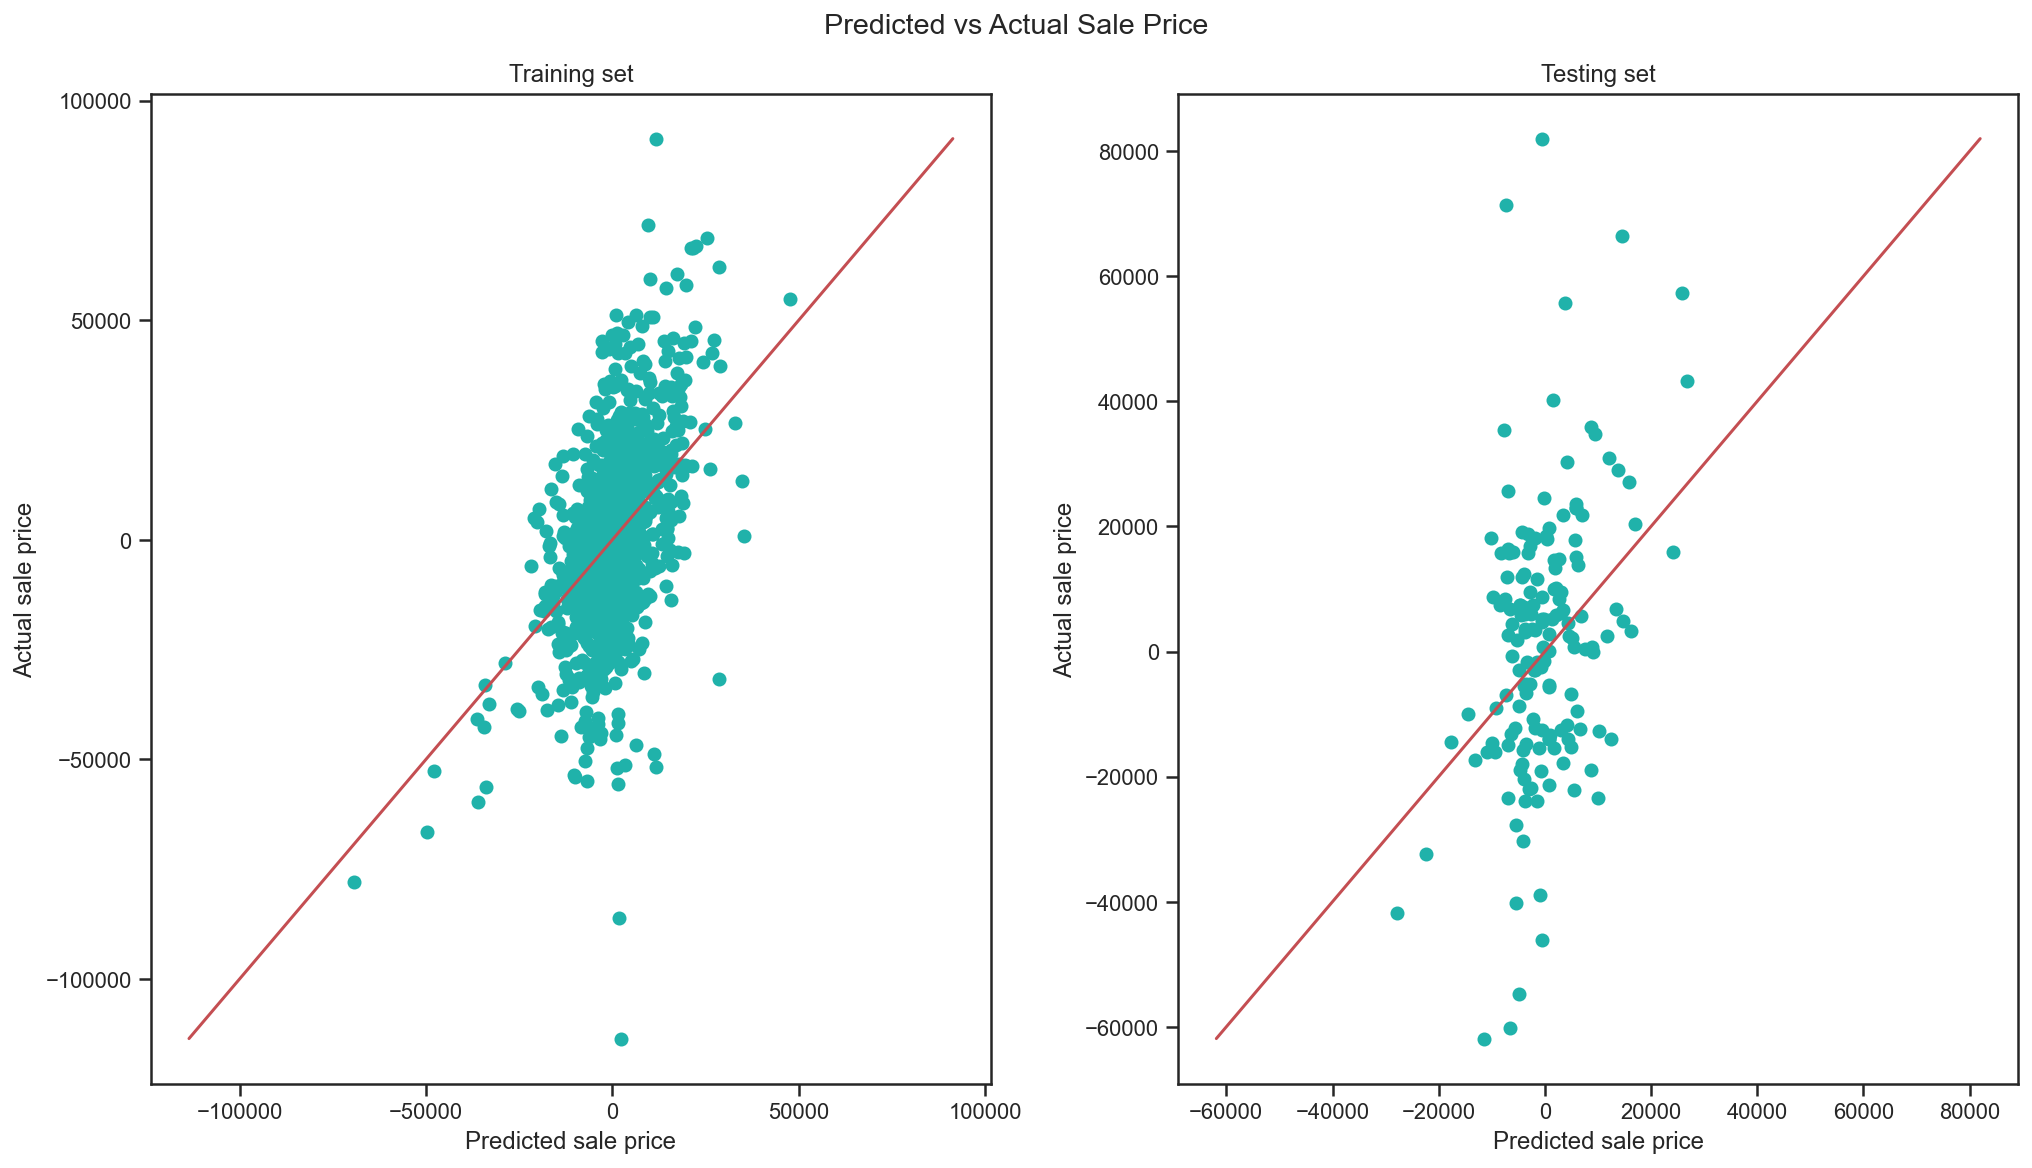

In [93]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8), constrained_layout=True)

fig.suptitle('Predicted vs Actual Sale Price')
ax[0].scatter(predicted_train2,y_train, color = 'lightseagreen')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r')
ax[0].set_ylabel('Actual sale price')
ax[0].set_xlabel('Predicted sale price')
ax[0].set_title('Training set')

ax[1].scatter(predicted_test2,y_test, color = 'lightseagreen')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
ax[1].set_ylabel('Actual sale price')
ax[1].set_xlabel('Predicted sale price')
ax[1].set_title('Testing set');

## Conclusion

The aim of the second modelling was to identify  which properties might sell for less than predicted - based on fixed features. This was done using residuals from the modelling based on the fixed features above. 
Negative residuals will be here the main focus, as they indicate the properies with high prediction price and lower actual price. Company would want to target this properties and invest in redecoration.    
In case of positive residual, the sale price is predicted to be lower than actual sale price. Company don't want to renovate this properties as they were more expensive than expected. 


The modelling using residuals from Q1 and renovateable features produced rather dissapointing scores (train of 0.2702,test of 1.385000e-01, cv of 0.1156). 
Again Ridge perfomed the best across all models, obtaining lowest RMSE of 21,327 USD. 



Amongs all predictors used, it seems only few are able to make impact. For instance, with every unit increase in overall quality, this feature counts for 4880.50 USD of the variance in the first model, meaning the increase in overall quality could potentially increase the house sale price by this amount. 

On the other hand choosing house with gable roof style, it will decrease the house sale price by 825.50 USD and with fireplaces the price of the house will decrease by 1286.50 USD.


Would I trust any of the models?
Estimating the sale price using the model based on fixed features is definitely much more accurate when compared with model based on renovateable features. It's a good indicator of which property are best to buy, based on their fixed features.